# Project: Forest area change 1992-2015

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

About 30 percent of the land surface is covered by forest on Earth, but during the history, forest area was decreasing because of the population growth, agriculture, wood industry, and other effects. According to some estimation [link](https://www.nationalgeographic.com/environment/global-warming/deforestation/), the rainforests could completely vanish in a hundred year with the current rate of deforestation.
Now I want to examine the changes in forest area during the 1992-2015 period. My goal is to find the countries, or a group of countries which lost the most forest, and other countries where the forest area even increased. I try to find some correlation among different population parameters as well.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


### The dataset
Source of the data: https://www.gapminder.org/data/

Data explanation:

Forest area: dataframe: df_forest - Forest area in square km.

Forest area ratio: dataframe: df_forest_ratio - Percent of land area.

Agricultural land ratio: dataframe: df_agrtoland - Percent of land area.

Agricultural land area: dataframe: df_agr_area - Agricultural land area calculated from df_agrtoland and df_area.

Agriculture, value added: dataframe: df_agrtogdp - Percent of GDP	
	
GDP per capita growth: dataframe: df_gdpgr - GDP per capita growth annual percent.
	
GDP per capita: dataframe: df_gdp_p - GDP divided by midyear population. (US$)	
	
Population density: dataframe: df_popd - Population density per square km.

Population growth: dataframe: df_popg - Annual population growth rate.

Total population: dataframe: df_pop_tot - Total population of the country.

Country area: dataframe: df_area - Surface area in square km.

df_agr_area (agricultural area of a country) will be calculated after cleaning the data.
Instead of one multi-index dataframe I used multiple dataframes. In this case with multiple dataframes it was more easy to comprehend the data.

I added the datasets to a dictionary. Later I will use dataframe manipulations which are very easy to do with dictionary comprehension or looping through a dictionary.

/ with df = pd.concat(df_dict).transpose() the dataframes could be converted to a single dataframe

In [2]:
# load data
df_dict = {}
df_forest = pd.read_csv('Data/forest_area_sq_km.csv')
df_dict['forest_area'] = df_forest
df_forest_ratio = pd.read_csv('Data/forest_coverage_percent.csv')
df_dict['forest_ratio'] = df_forest_ratio
df_popt = pd.read_csv('Data/population_total.csv')
df_dict['population_total'] = df_popt
df_popg = pd.read_csv('Data/population_growth_annual_percent.csv')
df_dict['population_growth'] = df_popg
df_popd = pd.read_csv('Data/population_density_per_square_km.csv')
df_dict['population_density'] = df_popd
df_gdpgr = pd.read_csv('Data/gdp_per_capita_yearly_growth.csv')
df_dict['gdp_growth_pc'] = df_gdpgr
df_gdp_tot = pd.read_csv('Data/total_gdp_us_inflation_adjusted.csv')
df_dict['gdp_tot'] = df_gdp_tot
df_gdp_pc = pd.read_csv('Data/gdppercapita_us_inflation_adjusted.csv')
df_dict['gdp_pc'] = df_gdp_pc
df_agrtoland = pd.read_csv('Data/agricultural_land_percent_of_land_area.csv')
df_dict['agricultural_land_ratio'] = df_agrtoland
df_agrtogdp = pd.read_csv('Data/agriculture_percent_of_gdp.csv')
df_dict['agricultural_gdp_ratio'] = df_agrtogdp
df_area = pd.read_csv('Data/surface_area_sq_km.csv')
df_dict['surface_area'] = df_area
df_dict.keys()

dict_keys(['forest_area', 'forest_ratio', 'population_total', 'population_growth', 'population_density', 'gdp_growth_pc', 'gdp_tot', 'gdp_pc', 'agricultural_land_ratio', 'agricultural_gdp_ratio', 'surface_area'])

In [3]:
def shape_data(df_toshape):
    """
    This function transforms the country column (geo) to the dataframe index, 
    drops the dates wich aren't in the range of the examination.
    Inplace is used to alter the original dataframe, but it is returned as well.
    Args:
        df_toshape (dataframe): dataframe to shape
    Return:
        the shaped dataframe
    """
    if 'geo' in df_toshape.columns:
        df_toshape.set_index('geo', inplace=True)
        early_dates = [x.astype(str) for x in list(df_toshape.columns.values.astype(int)) if x < 1992]
        late_dates = [x.astype(str) for x in list(df_toshape.columns.values.astype(int)) if x > 2015]
        drop_dates = early_dates + late_dates
        df_toshape.drop(drop_dates, axis=1, inplace=True)
        return df_toshape
    else:
        print("Column name 'geo' doesn't exist, returned the same dataframe.")
        return df_toshape    

### Examination of the dataset

First I check the shape of the datasets. Unfortunatelly they have different shapes.

In [4]:
for k, v in df_dict.items():
    print(k + ": ")
    print(v.shape)



forest_area: 
(193, 27)
forest_ratio: 
(192, 27)
population_total: 
(195, 220)
population_growth: 
(194, 59)
population_density: 
(195, 152)
gdp_growth_pc: 
(194, 220)
gdp_tot: 
(190, 59)
gdp_pc: 
(190, 59)
agricultural_land_ratio: 
(192, 56)
agricultural_gdp_ratio: 
(189, 59)
surface_area: 
(194, 58)


The dataframes have very different timeframes, and not all the countries are represented in all dataframes. Changing the axis could result in a more 'natural' table, but I left it as it is. My main goal is to examine the forest area, so the forest_are and forest_ratio tables are the most important ones. They have data between 1990 and 2015, so later I can drop the other columns from the other tables.

In [5]:
for k, v in df_dict.items():
    print(k + ": ")
    display(v.head())

forest_area: 


,geo,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Afghanistan,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,...,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0
1,Albania,7890.0,7870.0,7850.0,7830.0,7810.0,7790.0,7770.0,7750.0,7730.0,...,7810.0,7800.0,7790.0,7780.0,7760.0,7750.0,7740.0,7730.0,7720.0,7720.0
2,Algeria,16700.0,16600.0,16500.0,16400.0,16300.0,16200.0,16100.0,16100.0,16000.0,...,16100.0,16900.0,17700.0,18400.0,19200.0,19300.0,19300.0,19400.0,19500.0,19600.0
3,Andorra,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,...,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0
4,Angola,610000.0,609000.0,607000.0,606000.0,605000.0,604000.0,602000.0,601000.0,600000.0,...,590000.0,589000.0,587000.0,586000.0,585000.0,584000.0,582000.0,581000.0,580000.0,579000.0


forest_ratio: 


,geo,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Afghanistan,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,...,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07
1,Albania,28.80,28.70,28.60,28.60,28.50,28.40,28.40,28.30,28.20,...,28.50,28.50,28.40,28.40,28.30,28.30,28.30,28.20,28.20,28.20
2,Algeria,0.70,0.70,0.69,0.69,0.69,0.68,0.68,0.67,0.67,...,0.68,0.71,0.74,0.77,0.81,0.81,0.81,0.81,0.82,0.82
3,Andorra,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00,...,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00
4,Angola,48.90,48.80,48.70,48.60,48.50,48.40,48.30,48.20,48.10,...,47.30,47.20,47.10,47.00,46.90,46.80,46.70,46.60,46.50,46.40


population_total: 


,geo,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,3280000,3280000,3280000,3280000,3280000,3280000,3280000,3280000,3280000,...,28000000,28800000,29700000,30700000,31700000,32800000,33700000,34700000,35500000,36400000
1,Albania,410000,412000,413000,414000,416000,417000,418000,420000,421000,...,2960000,2940000,2930000,2920000,2920000,2920000,2920000,2930000,2930000,2930000
2,Algeria,2500000,2510000,2520000,2530000,2540000,2550000,2560000,2570000,2580000,...,35500000,36100000,36800000,37600000,38300000,39100000,39900000,40600000,41300000,42000000
3,Andorra,2650,2650,2650,2650,2650,2650,2650,2650,2650,...,84500,84400,83800,82400,80800,79200,78000,77300,77000,77000
4,Angola,1570000,1570000,1570000,1570000,1570000,1570000,1570000,1570000,1570000,...,22500000,23400000,24200000,25100000,26000000,26900000,27900000,28800000,29800000,30800000


population_growth: 


,geo,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,1.82,1.88,1.94,1.99,2.05,2.11,2.13,2.15,2.21,...,2.510,2.570,2.8100,3.100,3.270,3.320,3.180,2.940,2.690,2.490
1,Albania,3.02,3.12,3.06,2.95,2.88,2.75,2.63,2.63,2.84,...,-0.767,-0.674,-0.4960,-0.269,-0.165,-0.183,-0.207,-0.291,-0.160,-0.092
2,Algeria,2.51,2.49,2.47,2.49,2.56,2.66,2.76,2.84,2.88,...,1.620,1.720,1.8200,1.920,2.010,2.040,2.000,1.920,1.830,1.740
3,Andorra,7.05,6.94,6.69,6.56,6.24,6.00,5.75,5.50,5.31,...,1.410,0.714,-0.0154,-0.830,-1.590,-2.010,-1.960,-1.540,-0.944,-0.410
4,Angola,1.90,1.93,1.95,1.93,1.87,1.79,1.70,1.65,1.68,...,3.560,3.570,3.5700,3.570,3.560,3.530,3.490,3.430,3.370,3.310


population_density: 


,geo,1950,1951,1952,1953,1954,1955,1956,1957,1958,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,Afghanistan,11.90,12.00,12.20,12.30,12.50,12.70,12.90,13.10,13.30,...,110.0,110.0,110.0,109.0,109.0,109.0,109.0,108.0,108.0,108.0
1,Albania,46.10,47.00,48.00,49.20,50.50,51.80,53.30,54.70,56.30,...,66.3,65.6,64.9,64.2,63.6,62.9,62.3,61.7,61.1,60.5
2,Algeria,3.73,3.80,3.87,3.95,4.03,4.13,4.23,4.33,4.44,...,26.4,26.4,26.4,26.4,26.4,26.4,26.3,26.3,26.3,26.3
3,Andorra,13.20,14.20,15.40,16.70,18.10,19.60,21.30,22.90,24.70,...,137.0,137.0,136.0,136.0,136.0,135.0,135.0,135.0,135.0,134.0
4,Angola,3.65,3.74,3.83,3.92,4.01,4.10,4.19,4.27,4.36,...,125.0,127.0,128.0,130.0,131.0,133.0,134.0,136.0,137.0,139.0


gdp_growth_pc: 


,geo,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,5.170,3.850,11.20,1.13,0.837,2.11,2.68,2.760,3.02,3.38
1,Albania,0.10400,0.10400,0.10400,0.10400,0.10400,0.10400,0.10400,0.10400,0.10400,...,2.980,2.490,2.28,1.72,2.610,3.82,4.72,5.030,5.03,5.23
2,Algeria,-0.00247,-0.00247,-0.00247,-0.00247,-0.00247,-0.00247,-0.00247,-0.00247,-0.00247,...,2.060,0.857,1.16,1.61,2.180,2.10,2.36,2.500,2.63,2.68
3,Andorra,0.16600,0.16600,0.16600,0.16600,0.16600,0.16600,0.16600,0.16600,0.16600,...,-4.780,-4.300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,0.42500,0.42500,0.42500,0.42500,0.42500,0.42500,0.42500,0.42500,0.42500,...,0.594,1.030,2.13,1.03,2.240,2.46,2.77,0.262,3.46,3.55


gdp_tot: 


,geo,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.210000e+10,1.470000e+10,1.590000e+10,1.690000e+10,1.940000e+10,2.010000e+10,2.060000e+10,2.090000e+10,2.140000e+10,2.200000e+10
1,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.110000e+10,1.150000e+10,1.190000e+10,1.220000e+10,1.240000e+10,1.250000e+10,1.280000e+10,1.300000e+10,1.350000e+10,1.400000e+10
2,Algeria,2.740000e+10,2.370000e+10,1.900000e+10,2.560000e+10,2.710000e+10,2.870000e+10,2.740000e+10,2.990000e+10,3.320000e+10,...,1.530000e+11,1.560000e+11,1.610000e+11,1.660000e+11,1.710000e+11,1.760000e+11,1.830000e+11,1.900000e+11,1.960000e+11,1.990000e+11
3,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.680000e+09,3.550000e+09,3.360000e+09,3.200000e+09,3.150000e+09,3.160000e+09,3.230000e+09,3.260000e+09,3.320000e+09,3.380000e+09
4,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.790000e+10,7.980000e+10,8.250000e+10,8.570000e+10,9.020000e+10,9.630000e+10,1.010000e+11,1.040000e+11,1.030000e+11,1.040000e+11


gdp_pc: 


,geo,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,445.0,525.0,553,569.0,630.0,634.0,630.0,620.0,618.0,618.0
1,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3780.0,3930.0,4090,4210.0,4280.0,4330.0,4410.0,4520.0,4680.0,4870.0
2,Algeria,2470.0,2080.0,1630.0,2130.0,2200.0,2280.0,2110.0,2240.0,2410.0,...,4390.0,4390.0,4460,4500.0,4560.0,4600.0,4680.0,4760.0,4830.0,4830.0
3,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43900.0,42000.0,39700,38200.0,38200.0,39100.0,40800.0,41800.0,43000.0,43900.0
4,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3580.0,3540.0,3530,3540.0,3590.0,3710.0,3750.0,3730.0,3580.0,3480.0


agricultural_land_ratio: 


,geo,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Afghanistan,57.7,57.8,57.9,58.0,58.0,58.1,58.2,58.2,58.2,...,58.1,58.1,58.1,58.1,58.1,58.1,58.1,58.1,58.1,58.1
1,Albania,45.0,45.0,45.0,44.9,45.1,45.3,45.4,45.3,45.1,...,40.9,40.8,43.1,43.8,43.8,43.8,43.8,43.3,42.9,42.9
2,Algeria,19.1,18.9,18.7,18.5,18.5,18.5,18.6,18.6,18.6,...,17.3,17.3,17.3,17.4,17.4,17.4,17.4,17.4,17.4,17.4
3,Andorra,55.3,55.3,55.3,55.3,55.3,55.3,55.3,55.3,55.3,...,46.3,44.2,44.2,44.2,42.1,42.1,39.9,40.0,40.0,40.0
4,Angola,45.9,45.9,45.9,45.9,45.9,46.0,46.0,46.0,46.0,...,46.2,46.3,46.3,46.8,46.8,47.3,47.3,47.5,47.5,47.5


agricultural_gdp_ratio: 


,geo,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.700,29.100,26.10,23.600,23.600,22.600,22.000,20.50,21.000,NaN
1,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.800,16.800,18.00,18.200,18.800,19.600,20.000,19.80,19.900,19.0
2,Algeria,18.6,17.8,18.1,15.4,13.0,14.4,10.3,11.7,12.2,...,6.590,9.340,8.47,8.110,8.770,9.850,10.300,11.60,12.300,12.3
3,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.442,0.435,0.50,0.535,0.612,0.577,0.496,0.47,0.492,NaN
4,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


surface_area: 


,geo,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,...,653000.0,653000.0,653000.0,653000,653000,653000,653000,653000,653000,653000
1,Albania,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,...,28800.0,28800.0,28800.0,28800,28800,28800,28800,28800,28800,28800
2,Algeria,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,...,2380000.0,2380000.0,2380000.0,2380000,2380000,2380000,2380000,2380000,2380000,2380000
3,Andorra,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,...,470.0,470.0,470.0,470,470,470,470,470,470,470
4,Angola,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,...,1250000.0,1250000.0,1250000.0,1250000,1250000,1250000,1250000,1250000,1250000,1250000


The 'geo' column is a string in each dataframe, but most of the data is float or int. Some dataframes have both float and int, later I will convert these to the same type.

In [6]:
for k, v in df_dict.items():
    print(k + ": ")
    print(v.info())

forest_area: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 27 columns):
geo     193 non-null object
1990    192 non-null float64
1991    192 non-null float64
1992    192 non-null float64
1993    192 non-null float64
1994    192 non-null float64
1995    192 non-null float64
1996    192 non-null float64
1997    192 non-null float64
1998    192 non-null float64
1999    192 non-null float64
2000    192 non-null float64
2001    192 non-null float64
2002    192 non-null float64
2003    192 non-null float64
2004    192 non-null float64
2005    192 non-null float64
2006    192 non-null float64
2007    192 non-null float64
2008    192 non-null float64
2009    192 non-null float64
2010    192 non-null float64
2011    193 non-null float64
2012    193 non-null float64
2013    193 non-null float64
2014    193 non-null float64
2015    193 non-null float64
dtypes: float64(26), object(1)
memory usage: 40.8+ KB
None
forest_ratio: 
<class 'pandas.core.frame

Here we can see some base statistics for every year in the dataframes. In our case, this describes the statistics of countries for each year.

In [7]:
for k, v in df_dict.items():
    print(k + ": ")
    display(v.describe())

forest_area: 


,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
count,1.920000e+02,1.920000e+02,1.920000e+02,1.920000e+02,1.920000e+02,1.920000e+02,1.920000e+02,1.920000e+02,1.920000e+02,1.920000e+02,...,1.920000e+02,1.920000e+02,1.920000e+02,1.920000e+02,1.920000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02
mean,2.145522e+05,2.142037e+05,2.138679e+05,2.133308e+05,2.129860e+05,2.125831e+05,2.121329e+05,2.117903e+05,2.113730e+05,2.110449e+05,...,2.093810e+05,2.090529e+05,2.089973e+05,2.087250e+05,2.085574e+05,2.073080e+05,2.071676e+05,2.070069e+05,2.068406e+05,2.066927e+05
std,7.964985e+05,7.956537e+05,7.949771e+05,7.938801e+05,7.932194e+05,7.922300e+05,7.911591e+05,7.905268e+05,7.895641e+05,7.889537e+05,...,7.851442e+05,7.847846e+05,7.858126e+05,7.857882e+05,7.859819e+05,7.837924e+05,7.836656e+05,7.838346e+05,7.837072e+05,7.835367e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.425000e+03,3.417500e+03,3.417500e+03,3.407500e+03,3.407500e+03,3.407500e+03,3.400000e+03,3.405000e+03,3.385000e+03,3.360000e+03,...,3.372500e+03,3.365000e+03,3.300000e+03,3.272500e+03,3.275000e+03,3.310000e+03,3.310000e+03,3.320000e+03,3.320000e+03,3.320000e+03
50%,2.495000e+04,2.485000e+04,2.460000e+04,2.440000e+04,2.420000e+04,2.395000e+04,2.370000e+04,2.375000e+04,2.385000e+04,2.395000e+04,...,2.515000e+04,2.555000e+04,2.590000e+04,2.620000e+04,2.635000e+04,2.640000e+04,2.660000e+04,2.660000e+04,2.670000e+04,2.670000e+04
75%,1.047500e+05,1.047500e+05,1.047500e+05,1.055000e+05,1.055000e+05,1.070000e+05,1.092500e+05,1.107500e+05,1.130000e+05,1.135000e+05,...,1.072500e+05,1.075000e+05,1.077500e+05,1.080000e+05,1.082500e+05,1.070000e+05,1.070000e+05,1.070000e+05,1.070000e+05,1.070000e+05
max,8.090000e+06,8.090000e+06,8.090000e+06,8.090000e+06,8.090000e+06,8.090000e+06,8.090000e+06,8.090000e+06,8.090000e+06,8.090000e+06,...,8.100000e+06,8.110000e+06,8.130000e+06,8.140000e+06,8.150000e+06,8.150000e+06,8.150000e+06,8.150000e+06,8.150000e+06,8.150000e+06


forest_ratio: 


,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
count,162.000000,165.000000,184.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,...,192.000000,192.000000,192.000000,192.000000,192.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,32.718025,33.538848,32.764022,32.566649,32.558989,32.503617,32.443564,32.386436,32.363191,32.305372,...,31.991615,31.969115,31.946354,31.921719,31.893750,31.972513,31.954974,31.928639,31.907068,31.879267
std,25.223341,25.750489,25.124209,24.838884,24.804592,24.721646,24.644216,24.572324,24.526291,24.461190,...,23.896402,23.871671,23.853312,23.839235,23.825992,23.824116,23.810324,23.793296,23.783266,23.775307
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.500000,11.600000,10.975000,11.325000,11.100000,11.025000,11.025000,11.025000,11.050000,11.050000,...,11.200000,11.250000,11.075000,11.075000,11.100000,11.100000,11.050000,11.050000,11.000000,10.950000
50%,28.800000,29.200000,29.300000,29.500000,30.000000,30.350000,30.050000,30.150000,30.200000,30.300000,...,31.450000,31.400000,31.450000,31.500000,31.550000,31.900000,31.900000,32.000000,32.000000,32.100000
75%,52.025000,52.800000,51.675000,51.350000,51.500000,51.275000,51.050000,50.800000,50.750000,50.375000,...,49.625000,49.775000,49.600000,49.250000,48.850000,48.450000,48.100000,47.750000,47.650000,47.900000
max,98.900000,98.900000,98.900000,98.800000,98.800000,98.800000,98.800000,98.700000,98.700000,98.700000,...,98.500000,98.500000,98.500000,98.400000,98.400000,98.400000,98.400000,98.300000,98.300000,98.300000


population_total: 


,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
count,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,...,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02
mean,4.858439e+06,4.875184e+06,4.896420e+06,4.921854e+06,4.944249e+06,4.965603e+06,4.987121e+06,5.008500e+06,5.029397e+06,5.056351e+06,...,3.501814e+07,3.548854e+07,3.594759e+07,3.636227e+07,3.679066e+07,3.719926e+07,3.767774e+07,3.804907e+07,3.851844e+07,3.895188e+07
std,2.623298e+07,2.635925e+07,2.654860e+07,2.676926e+07,2.695929e+07,2.714956e+07,2.730824e+07,2.749855e+07,2.768943e+07,2.791149e+07,...,1.337925e+08,1.353420e+08,1.368709e+08,1.379478e+08,1.390020e+08,1.400783e+08,1.416266e+08,1.422209e+08,1.437690e+08,1.448713e+08
min,9.050000e+02,9.050000e+02,9.050000e+02,9.050000e+02,9.050000e+02,9.050000e+02,9.050000e+02,9.050000e+02,9.050000e+02,9.050000e+02,...,7.950000e+02,7.940000e+02,7.960000e+02,8.040000e+02,8.010000e+02,8.000000e+02,8.030000e+02,8.010000e+02,7.920000e+02,8.010000e+02
25%,1.120000e+05,1.120000e+05,1.120000e+05,1.120000e+05,1.120000e+05,1.120000e+05,1.120000e+05,1.120000e+05,1.120000e+05,1.120000e+05,...,1.590000e+06,1.665000e+06,1.725000e+06,1.780000e+06,1.840000e+06,1.900000e+06,1.955000e+06,1.975000e+06,1.990000e+06,2.000000e+06
50%,7.130000e+05,7.130000e+05,7.130000e+05,7.130000e+05,7.130000e+05,7.130000e+05,7.130000e+05,7.130000e+05,7.130000e+05,7.170000e+05,...,7.460000e+06,7.430000e+06,7.570000e+06,7.990000e+06,8.130000e+06,8.230000e+06,8.320000e+06,8.400000e+06,8.480000e+06,8.540000e+06
75%,2.120000e+06,2.120000e+06,2.120000e+06,2.120000e+06,2.120000e+06,2.120000e+06,2.120000e+06,2.120000e+06,2.120000e+06,2.120000e+06,...,2.325000e+07,2.390000e+07,2.450000e+07,2.500000e+07,2.580000e+07,2.655000e+07,2.725000e+07,2.790000e+07,2.855000e+07,2.920000e+07
max,3.220000e+08,3.240000e+08,3.270000e+08,3.300000e+08,3.330000e+08,3.360000e+08,3.380000e+08,3.410000e+08,3.440000e+08,3.470000e+08,...,1.350000e+09,1.360000e+09,1.370000e+09,1.380000e+09,1.380000e+09,1.390000e+09,1.400000e+09,1.400000e+09,1.410000e+09,1.420000e+09


population_growth: 


,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
count,191.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,...,194.000000,194.000000,194.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,2.353517,2.332287,2.352344,2.344419,2.333380,2.297589,2.267584,2.251952,2.207820,2.189104,...,1.631345,1.584846,1.528262,1.467285,1.470765,1.465266,1.460253,1.423703,1.393022,1.358827
std,1.308387,1.424190,1.516222,1.530960,1.477462,1.420376,1.403649,1.422780,1.436988,1.483269,...,1.863377,1.676872,1.536419,1.512258,1.449622,1.444638,1.448571,1.254813,1.162510,1.133521
min,-0.281000,-1.020000,-0.444000,-0.869000,-1.180000,-1.440000,-1.750000,-2.040000,-2.090000,-1.890000,...,-1.670000,-1.650000,-2.100000,-2.630000,-2.150000,-3.040000,-3.110000,-2.470000,-1.640000,-1.420000
25%,1.570000,1.475000,1.417500,1.435000,1.447500,1.477500,1.495000,1.385000,1.310000,1.285000,...,0.604500,0.526750,0.491750,0.436000,0.464000,0.489000,0.480000,0.508000,0.519000,0.518000
50%,2.300000,2.350000,2.335000,2.300000,2.295000,2.280000,2.345000,2.340000,2.230000,2.235000,...,1.355000,1.300000,1.290000,1.300000,1.290000,1.280000,1.300000,1.220000,1.260000,1.250000
75%,2.985000,2.975000,2.980000,2.952500,2.927500,2.912500,2.880000,2.902500,2.882500,2.870000,...,2.377500,2.390000,2.352500,2.330000,2.310000,2.310000,2.320000,2.350000,2.240000,2.160000
max,10.300000,11.100000,11.600000,11.600000,11.300000,10.800000,10.300000,9.820000,9.210000,10.700000,...,15.500000,13.500000,11.200000,9.250000,7.760000,7.060000,9.110000,5.860000,5.220000,4.670000


population_density: 


,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,143.611697,142.462267,142.640882,144.024097,146.077179,149.245215,152.310990,156.464559,160.047015,163.183415,...,483.038769,483.607436,484.564410,485.497077,486.435487,486.927077,487.930000,488.760051,489.130615,490.027795
std,974.815958,946.797482,933.258752,934.026160,941.992930,964.044928,985.894712,1021.827737,1050.623775,1072.468946,...,2843.051075,2849.496701,2862.878473,2876.213955,2889.636444,2896.108338,2909.639164,2923.080055,2929.523922,2942.967289
min,0.502000,0.511000,0.520000,0.530000,0.540000,0.550000,0.561000,0.573000,0.586000,0.600000,...,2.910000,2.910000,2.920000,2.920000,2.920000,2.920000,2.920000,2.920000,2.920000,2.920000
25%,7.970000,8.110000,8.235000,8.370000,8.520000,8.690000,8.930000,9.085000,9.430000,9.680000,...,48.300000,48.250000,48.200000,48.150000,48.150000,48.200000,48.400000,48.600000,48.750000,48.800000
50%,25.700000,26.200000,26.500000,26.800000,27.100000,27.300000,27.600000,27.900000,28.200000,28.700000,...,119.000000,119.000000,118.000000,119.000000,120.000000,121.000000,122.000000,124.000000,125.000000,126.000000
75%,74.800000,75.200000,76.050000,77.100000,78.250000,79.750000,82.600000,84.400000,85.050000,85.550000,...,271.000000,271.000000,270.500000,269.000000,268.000000,267.000000,266.000000,265.000000,264.000000,263.000000
max,13400.000000,13000.000000,12800.000000,12800.000000,12900.000000,13200.000000,13500.000000,14000.000000,14400.000000,14700.000000,...,38800.000000,38900.000000,39100.000000,39300.000000,39500.000000,39600.000000,39800.000000,40000.000000,40100.000000,40300.000000


gdp_growth_pc: 


,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,...,193.000000,193.00000,188.000000,184.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,0.058499,0.109670,0.043359,0.039485,0.084038,0.079709,0.104914,-0.122888,0.056065,0.235972,...,2.855765,2.29457,2.245695,1.760447,2.346237,2.904376,2.979047,2.831675,2.885107,2.809947
std,0.211156,0.432006,0.363247,0.588458,0.740316,0.288300,0.787177,1.469541,0.546729,1.588021,...,3.915776,6.21296,8.844492,4.325484,2.386185,3.102803,2.469769,1.955071,2.131198,2.133706
min,-1.300000,-0.403000,-3.230000,-6.520000,-5.230000,-1.820000,-4.150000,-12.400000,-4.570000,-7.760000,...,-8.530000,-61.60000,-50.000000,-37.300000,-9.160000,-10.700000,-1.760000,-7.960000,-10.100000,-11.700000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.791000,0.63400,-0.050550,0.460500,1.072500,1.460000,1.492500,1.497500,1.622500,1.600000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.670000,2.14000,1.715000,1.685000,2.195000,2.555000,2.650000,2.665000,2.755000,2.685000
75%,0.104000,0.104000,0.104000,0.104000,0.104000,0.104000,0.104000,0.104000,0.104000,0.104000,...,5.010000,4.72000,4.050000,3.420000,3.457500,3.665000,3.922500,3.917500,3.815000,3.805000
max,1.850000,4.620000,2.870000,4.330000,6.400000,2.450000,8.410000,5.790000,4.900000,14.900000,...,22.800000,20.60000,102.000000,18.700000,11.500000,27.900000,23.700000,8.610000,14.600000,14.800000


gdp_tot: 


,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
count,8.800000e+01,8.900000e+01,8.900000e+01,8.900000e+01,8.900000e+01,9.300000e+01,9.600000e+01,9.700000e+01,9.900000e+01,9.900000e+01,...,1.870000e+02,1.870000e+02,1.900000e+02,1.870000e+02,1.860000e+02,1.860000e+02,1.860000e+02,1.850000e+02,1.840000e+02,1.830000e+02
mean,1.024139e+11,1.057267e+11,1.115651e+11,1.173542e+11,1.251986e+11,1.267502e+11,1.300288e+11,1.344054e+11,1.407409e+11,1.493698e+11,...,3.391049e+11,3.333079e+11,3.422419e+11,3.585630e+11,3.693001e+11,3.791101e+11,3.898859e+11,4.012928e+11,4.130283e+11,4.286074e+11
std,3.532207e+11,3.621875e+11,3.841504e+11,4.024428e+11,4.271311e+11,4.443782e+11,4.662309e+11,4.803208e+11,5.020176e+11,5.240405e+11,...,1.301430e+12,1.274163e+12,1.312405e+12,1.352894e+12,1.391061e+12,1.428631e+12,1.471993e+12,1.526638e+12,1.564845e+12,1.620775e+12
min,9.870000e+07,1.040000e+08,1.090000e+08,1.140000e+08,1.200000e+08,1.260000e+08,1.320000e+08,1.360000e+08,1.450000e+08,1.490000e+08,...,3.420000e+07,3.270000e+07,3.180000e+07,3.420000e+07,3.290000e+07,3.440000e+07,3.490000e+07,3.810000e+07,3.920000e+07,4.050000e+07
25%,2.165000e+09,2.280000e+09,2.410000e+09,2.620000e+09,2.900000e+09,3.020000e+09,3.177500e+09,3.180000e+09,3.510000e+09,3.645000e+09,...,5.890000e+09,5.970000e+09,5.732500e+09,6.615000e+09,7.252500e+09,7.572500e+09,7.850000e+09,8.310000e+09,8.647500e+09,9.060000e+09
50%,8.910000e+09,8.830000e+09,8.950000e+09,9.260000e+09,9.580000e+09,7.950000e+09,8.145000e+09,8.560000e+09,9.500000e+09,9.950000e+09,...,2.400000e+10,2.460000e+10,2.320000e+10,2.560000e+10,2.675000e+10,2.865000e+10,2.940000e+10,3.020000e+10,2.985000e+10,3.140000e+10
75%,6.872500e+10,7.280000e+10,7.900000e+10,8.480000e+10,9.260000e+10,8.310000e+10,7.462500e+10,7.170000e+10,7.695000e+10,8.190000e+10,...,1.615000e+11,1.635000e+11,1.577500e+11,1.680000e+11,1.717500e+11,1.817500e+11,1.840000e+11,1.910000e+11,2.035000e+11,2.130000e+11
max,3.080000e+12,3.150000e+12,3.340000e+12,3.490000e+12,3.690000e+12,3.930000e+12,4.180000e+12,4.290000e+12,4.490000e+12,4.630000e+12,...,1.500000e+13,1.460000e+13,1.500000e+13,1.520000e+13,1.550000e+13,1.580000e+13,1.620000e+13,1.670000e+13,1.690000e+13,1.730000e+13


gdp_pc: 


,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
count,88.000000,89.000000,89.000000,89.000000,89.000000,93.000000,96.000000,97.000000,99.000000,99.000000,...,187.000000,187.000000,190.000000,187.000000,186.000000,186.000000,186.000000,185.000000,184.000000,183.000000
mean,4622.500000,4740.325843,4883.808989,5044.146067,5298.224719,5331.537634,5355.604167,5469.247423,5769.626263,6070.545455,...,13096.508021,12494.850267,13966.078947,12787.668449,12904.198925,12987.623656,13155.446237,13380.529730,13579.945652,13861.781421
std,6259.530721,6474.995954,6668.398816,6881.558232,7284.774644,7401.639525,7497.344196,7705.354775,7986.131163,8434.129299,...,19030.226639,17930.998978,22366.413612,18167.977557,18000.075075,18028.891032,18253.648558,18648.762614,18890.299898,19122.670759
min,159.000000,141.000000,132.000000,142.000000,163.000000,176.000000,164.000000,150.000000,164.000000,166.000000,...,230.000000,230.000000,231.000000,234.000000,236.000000,239.000000,243.000000,227.000000,218.000000,213.000000
25%,711.000000,711.000000,712.000000,708.000000,698.000000,763.000000,750.750000,737.000000,757.500000,767.000000,...,1320.000000,1340.000000,1400.000000,1465.000000,1562.500000,1635.000000,1680.000000,1760.000000,1830.000000,1960.000000
50%,1485.000000,1480.000000,1490.000000,1460.000000,1550.000000,1680.000000,1685.000000,1650.000000,1690.000000,1780.000000,...,4620.000000,4550.000000,4670.000000,4940.000000,5390.000000,5615.000000,5590.000000,5660.000000,5800.000000,5810.000000
75%,5147.500000,5540.000000,5380.000000,5330.000000,5710.000000,6040.000000,5655.000000,5700.000000,6405.000000,6850.000000,...,14800.000000,13850.000000,13650.000000,13900.000000,14000.000000,14450.000000,14850.000000,14900.000000,15250.000000,15700.000000
max,27100.000000,27900.000000,27900.000000,28600.000000,30500.000000,29900.000000,30000.000000,30300.000000,31200.000000,34100.000000,...,109000.000000,102000.000000,144000.000000,105000.000000,102000.000000,104000.000000,107000.000000,108000.000000,109000.000000,108000.000000


agricultural_land_ratio: 


,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
count,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,...,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,36.856699,36.913055,37.070135,37.155423,37.268282,37.299270,37.351380,37.407393,37.521656,37.444767,...,39.567276,39.498380,39.644813,39.555234,39.582771,39.515328,39.563432,39.504849,39.473260,39.467271
std,22.795314,22.766901,22.725493,22.688569,22.551385,22.480961,22.499071,22.458088,22.512108,22.365584,...,21.717991,21.739476,21.819210,21.703212,21.720026,21.758756,21.717838,21.797754,21.823101,21.789930
min,0.263000,0.269000,0.263000,0.295000,0.301000,0.282000,0.276000,0.276000,0.301000,0.308000,...,0.467000,0.449000,0.454000,0.515000,0.502000,0.513000,0.469000,0.533000,0.565000,0.565000
25%,19.000000,18.900000,19.100000,19.150000,19.250000,19.250000,19.400000,19.350000,19.350000,19.250000,...,21.050000,21.125000,21.050000,21.800000,22.200000,22.175000,22.400000,21.675000,21.675000,21.675000
50%,36.200000,36.400000,36.500000,36.500000,37.800000,38.000000,38.000000,38.000000,38.000000,38.000000,...,40.000000,40.100000,40.950000,40.250000,40.500000,40.200000,39.950000,40.250000,40.250000,40.150000
75%,55.100000,54.500000,54.700000,54.900000,55.100000,55.350000,55.500000,55.300000,55.200000,55.250000,...,57.000000,56.850000,57.350000,56.925000,56.050000,56.200000,55.825000,55.675000,55.750000,56.575000
max,93.400000,92.800000,92.200000,91.900000,91.300000,90.900000,90.600000,90.600000,90.500000,90.600000,...,84.000000,83.100000,83.800000,84.600000,82.500000,83.000000,81.300000,82.600000,82.600000,82.600000


agricultural_gdp_ratio: 


,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
count,43.000000,45.000000,45.000000,46.000000,48.000000,64.000000,67.000000,68.000000,71.000000,72.000000,...,182.000000,181.000000,181.000000,181.000000,181.000000,183.000000,182.000000,179.000000,172.000000,143.000000
mean,35.493488,36.523778,35.983778,35.591739,34.057292,32.327344,30.819851,30.315294,28.432535,27.363611,...,12.178531,12.125331,11.773490,11.650288,11.554826,11.241279,11.038714,11.101777,10.933069,11.223584
std,18.047385,18.511119,17.992930,17.323559,16.826924,16.426719,15.860177,15.194186,15.396765,15.379514,...,12.638880,12.206917,11.829582,11.699791,11.823286,11.177642,11.015564,11.187666,11.110840,11.476185
min,3.710000,3.510000,3.590000,3.250000,3.330000,3.070000,3.270000,3.050000,3.050000,2.810000,...,0.041600,0.041000,0.036700,0.034500,0.033200,0.034000,0.035000,0.031100,0.029900,0.026500
25%,23.400000,23.900000,23.500000,22.850000,22.375000,20.625000,20.100000,20.200000,17.150000,15.975000,...,2.630000,2.800000,2.570000,2.830000,2.660000,2.770000,2.505000,2.570000,2.377500,2.680000
50%,35.300000,35.800000,37.600000,38.200000,34.650000,31.000000,30.300000,29.600000,28.300000,27.050000,...,7.460000,8.100000,7.530000,8.070000,7.530000,7.620000,6.785000,7.040000,6.930000,7.160000
75%,46.100000,46.400000,45.900000,44.075000,42.000000,41.450000,39.000000,39.825000,38.150000,36.525000,...,19.150000,17.900000,17.500000,17.200000,17.600000,17.550000,17.025000,16.650000,16.150000,15.500000
max,88.200000,89.400000,88.200000,83.800000,81.700000,79.300000,74.900000,70.700000,69.200000,66.400000,...,65.200000,58.000000,52.900000,54.600000,54.900000,50.000000,51.800000,58.700000,58.200000,60.300000


surface_area: 


,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
count,1.870000e+02,1.870000e+02,1.870000e+02,1.870000e+02,1.870000e+02,1.870000e+02,1.870000e+02,1.870000e+02,1.870000e+02,1.870000e+02,...,1.930000e+02,1.930000e+02,1.930000e+02,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02
mean,7.145020e+05,7.145020e+05,7.145020e+05,7.145020e+05,7.145020e+05,7.145020e+05,7.145020e+05,7.145020e+05,7.145020e+05,7.145020e+05,...,6.932975e+05,6.932856e+05,6.932908e+05,6.897893e+05,6.897728e+05,6.897728e+05,6.897625e+05,6.897625e+05,6.897625e+05,6.897625e+05
std,1.950665e+06,1.950665e+06,1.950665e+06,1.950665e+06,1.950665e+06,1.950665e+06,1.950665e+06,1.950665e+06,1.950665e+06,1.950665e+06,...,1.928482e+06,1.928483e+06,1.928483e+06,1.920930e+06,1.920933e+06,1.920933e+06,1.920935e+06,1.920935e+06,1.920935e+06,1.920935e+06
min,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
25%,2.705000e+04,2.705000e+04,2.705000e+04,2.705000e+04,2.705000e+04,2.705000e+04,2.705000e+04,2.705000e+04,2.705000e+04,2.705000e+04,...,2.320000e+04,2.320000e+04,2.320000e+04,2.382500e+04,2.382500e+04,2.382500e+04,2.382500e+04,2.382500e+04,2.382500e+04,2.382500e+04
50%,1.320000e+05,1.320000e+05,1.320000e+05,1.320000e+05,1.320000e+05,1.320000e+05,1.320000e+05,1.320000e+05,1.320000e+05,1.320000e+05,...,1.180000e+05,1.180000e+05,1.180000e+05,1.195000e+05,1.195000e+05,1.195000e+05,1.195000e+05,1.195000e+05,1.195000e+05,1.195000e+05
75%,5.385000e+05,5.385000e+05,5.385000e+05,5.385000e+05,5.385000e+05,5.385000e+05,5.385000e+05,5.385000e+05,5.385000e+05,5.385000e+05,...,5.130000e+05,5.130000e+05,5.130000e+05,5.242500e+05,5.242500e+05,5.242500e+05,5.242500e+05,5.242500e+05,5.242500e+05,5.242500e+05
max,1.710000e+07,1.710000e+07,1.710000e+07,1.710000e+07,1.710000e+07,1.710000e+07,1.710000e+07,1.710000e+07,1.710000e+07,1.710000e+07,...,1.710000e+07,1.710000e+07,1.710000e+07,1.710000e+07,1.710000e+07,1.710000e+07,1.710000e+07,1.710000e+07,1.710000e+07,1.710000e+07


### Data Cleaning

With the 'datashape()' function I transform the 'geo' column (which is the country list) to the index of the dataframe. After that, I drop all the years I don't want to use. The most important dartaframes (df_forest, df_forest_ratio) has data between 1990 and 2015, but I use 1992 and 2015 because df_forest_ratio has a lot of missing data in the first two years.

'datashape()' function uses 'inplace=True' argument inside. This way doesn't arise new object, and the dataframes in df_dict remained the same objects.

In [8]:
df_dict = {k: shape_data(v) for k, v in df_dict.items()}

After transforming the 'string' 'geo' column to index we have only numerical data, so it is easy to mass-convert the dataframes with 'int' and 'float' to 'float'. Unfortunately 'astype()' doesn't have 'inplace' argument, it gives back a new object, so I have to update df_dict as well. 

In [9]:
df_gdp_pc = df_gdp_pc.astype(float)
df_dict['gdp_pc'] = df_gdp_pc
df_area = df_area.astype(float)
df_dict['surface_area'] = df_area

We will need an other dataframe, the agricultural land area. We calculate this from the country land area and the country agricultural land area percent:

In [10]:
# we have the proper indexes now, so make a new dataframe
df_agr_area = df_agrtoland.apply(axis=1, func=(lambda x: x.multiply(df_area['2015'].loc[x.name])*0.01))
df_dict['agro_area'] = df_agr_area

In [11]:
for k, v in df_dict.items():
    print(k + ": ")
    display(v.head())

forest_area: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,...,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0
Albania,7850.0,7830.0,7810.0,7790.0,7770.0,7750.0,7730.0,7710.0,7690.0,7720.0,...,7810.0,7800.0,7790.0,7780.0,7760.0,7750.0,7740.0,7730.0,7720.0,7720.0
Algeria,16500.0,16400.0,16300.0,16200.0,16100.0,16100.0,16000.0,15900.0,15800.0,15700.0,...,16100.0,16900.0,17700.0,18400.0,19200.0,19300.0,19300.0,19400.0,19500.0,19600.0
Andorra,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,...,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0
Angola,607000.0,606000.0,605000.0,604000.0,602000.0,601000.0,600000.0,599000.0,597000.0,596000.0,...,590000.0,589000.0,587000.0,586000.0,585000.0,584000.0,582000.0,581000.0,580000.0,579000.0


forest_ratio: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,...,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07
Albania,28.60,28.60,28.50,28.40,28.40,28.30,28.20,28.10,28.10,28.20,...,28.50,28.50,28.40,28.40,28.30,28.30,28.30,28.20,28.20,28.20
Algeria,0.69,0.69,0.69,0.68,0.68,0.67,0.67,0.67,0.66,0.66,...,0.68,0.71,0.74,0.77,0.81,0.81,0.81,0.81,0.82,0.82
Andorra,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00,...,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00
Angola,48.70,48.60,48.50,48.40,48.30,48.20,48.10,48.00,47.90,47.80,...,47.30,47.20,47.10,47.00,46.90,46.80,46.70,46.60,46.50,46.40


population_total: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,14000000,15100000,16200000,17100000,17800000,18400000,18900000,19400000,20100000,21000000,...,25900000,26600000,27300000,28000000,28800000,29700000,30700000,31700000,32800000,33700000
Albania,3240000,3190000,3140000,3110000,3090000,3090000,3100000,3120000,3120000,3120000,...,3050000,3020000,2990000,2960000,2940000,2930000,2920000,2920000,2920000,2920000
Algeria,27200000,27800000,28400000,28900000,29400000,29900000,30300000,30800000,31200000,31600000,...,33800000,34300000,34900000,35500000,36100000,36800000,37600000,38300000,39100000,39900000
Andorra,58900,61000,62700,63900,64400,64300,64100,64400,65400,67300,...,81000,82700,83900,84500,84400,83800,82400,80800,79200,78000
Angola,13000000,13400000,13800000,14300000,14700000,15100000,15500000,15900000,16400000,17000000,...,20300000,21000000,21800000,22500000,23400000,24200000,25100000,26000000,26900000,27900000


population_growth: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,7.330,7.67,6.900,5.570,4.140,3.0900,2.590,2.820,3.490,4.250,...,3.230,2.760,2.510,2.570,2.8100,3.100,3.270,3.320,3.180,2.940
Albania,-0.606,-0.61,-0.614,-0.618,-0.622,-0.6250,-0.629,-0.633,-0.637,-0.938,...,-0.631,-0.756,-0.767,-0.674,-0.4960,-0.269,-0.165,-0.183,-0.207,-0.291
Algeria,2.330,2.20,2.050,1.890,1.740,1.6000,1.490,1.410,1.350,1.300,...,1.460,1.530,1.620,1.720,1.8200,1.920,2.010,2.040,2.000,1.920
Andorra,3.840,3.48,2.760,1.850,0.796,-0.0513,-0.288,0.355,1.570,2.940,...,2.660,2.070,1.410,0.714,-0.0154,-0.830,-1.590,-2.010,-1.960,-1.540
Angola,3.250,3.30,3.210,3.040,2.860,2.7300,2.720,2.830,3.030,3.250,...,3.570,3.560,3.560,3.570,3.5700,3.570,3.560,3.530,3.490,3.430


population_density: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,21.4,23.1,24.8,26.2,27.3,28.2,28.9,29.7,30.8,32.1,...,39.7,40.8,41.8,42.9,44.1,45.5,47.0,48.6,50.2,51.7
Albania,118.0,116.0,115.0,113.0,113.0,113.0,113.0,114.0,114.0,114.0,...,111.0,110.0,109.0,108.0,107.0,107.0,107.0,107.0,107.0,107.0
Algeria,11.4,11.7,11.9,12.1,12.3,12.5,12.7,12.9,13.1,13.3,...,14.2,14.4,14.6,14.9,15.2,15.5,15.8,16.1,16.4,16.7
Andorra,125.0,130.0,133.0,136.0,137.0,137.0,136.0,137.0,139.0,143.0,...,172.0,176.0,178.0,180.0,180.0,178.0,175.0,172.0,169.0,166.0
Angola,10.4,10.8,11.1,11.4,11.8,12.1,12.4,12.8,13.2,13.6,...,16.3,16.8,17.5,18.1,18.7,19.4,20.1,20.9,21.6,22.3


gdp_growth_pc: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,-7.950,-13.90,-10.40,20.300,2.66,2.820,2.83,2.710,-1.0500,-10.400,...,1.590,10.80,0.117,17.300,5.170,3.850,11.20,1.13,0.837,2.11
Albania,-8.100,8.78,7.44,12.600,8.65,-10.600,12.30,9.580,6.7900,6.690,...,5.270,5.41,6.840,2.910,2.980,2.490,2.28,1.72,2.610,3.82
Algeria,-0.752,-4.44,-3.07,1.710,1.94,-0.558,3.50,1.680,0.9950,1.130,...,0.188,1.85,0.472,0.179,2.060,0.857,1.16,1.61,2.180,2.10
Andorra,-3.740,-5.65,-1.65,-0.114,3.09,8.590,3.30,4.010,0.4010,10.000,...,2.370,-1.70,-5.600,-6.310,-4.780,-4.300,NaN,NaN,NaN,NaN
Angola,-8.830,-26.40,-1.86,11.600,16.60,2.700,-2.63,0.387,-0.0561,-0.171,...,15.000,19.60,10.600,-0.464,0.594,1.030,2.13,1.03,2.240,2.46


gdp_tot: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.030000e+10,1.170000e+10,1.210000e+10,1.470000e+10,1.590000e+10,1.690000e+10,1.940000e+10,2.010000e+10,2.060000e+10,2.090000e+10
Albania,4.180000e+09,4.580000e+09,4.970000e+09,5.630000e+09,6.140000e+09,5.470000e+09,5.970000e+09,6.770000e+09,7.220000e+09,7.800000e+09,...,1.010000e+10,1.070000e+10,1.110000e+10,1.150000e+10,1.190000e+10,1.220000e+10,1.240000e+10,1.250000e+10,1.280000e+10,1.300000e+10
Algeria,9.250000e+10,9.060000e+10,8.980000e+10,9.320000e+10,9.700000e+10,9.810000e+10,1.030000e+11,1.060000e+11,1.100000e+11,1.140000e+11,...,1.450000e+11,1.500000e+11,1.530000e+11,1.560000e+11,1.610000e+11,1.660000e+11,1.710000e+11,1.760000e+11,1.830000e+11,1.900000e+11
Andorra,2.020000e+09,2.000000e+09,2.050000e+09,2.100000e+09,2.200000e+09,2.400000e+09,2.480000e+09,2.580000e+09,2.670000e+09,2.790000e+09,...,4.030000e+09,4.030000e+09,3.680000e+09,3.550000e+09,3.360000e+09,3.200000e+09,3.150000e+09,3.160000e+09,3.230000e+09,3.260000e+09
Angola,2.380000e+10,1.810000e+10,1.830000e+10,2.110000e+10,2.390000e+10,2.570000e+10,2.690000e+10,2.740000e+10,2.830000e+10,2.950000e+10,...,5.560000e+10,6.840000e+10,7.790000e+10,7.980000e+10,8.250000e+10,8.570000e+10,9.020000e+10,9.630000e+10,1.010000e+11,1.040000e+11


gdp_pc: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,398.0,440.0,445.0,525.0,553.0,569.0,630.0,634.0,630.0,620.0
Albania,1290.0,1420.0,1550.0,1760.0,1940.0,1740.0,1910.0,2180.0,2340.0,2550.0,...,3380.0,3610.0,3780.0,3930.0,4090.0,4210.0,4280.0,4330.0,4410.0,4520.0
Algeria,3400.0,3260.0,3160.0,3220.0,3300.0,3280.0,3400.0,3460.0,3540.0,3600.0,...,4280.0,4360.0,4390.0,4390.0,4460.0,4500.0,4560.0,4600.0,4680.0,4760.0
Andorra,34300.0,32800.0,32600.0,32900.0,34200.0,37300.0,38600.0,40000.0,40800.0,41400.0,...,49700.0,48700.0,43900.0,42000.0,39700.0,38200.0,38200.0,39100.0,40800.0,41800.0
Angola,1830.0,1350.0,1320.0,1480.0,1630.0,1700.0,1730.0,1720.0,1720.0,1740.0,...,2740.0,3260.0,3580.0,3540.0,3530.0,3540.0,3590.0,3710.0,3750.0,3730.0


agricultural_land_ratio: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,58.3,58.1,57.9,57.8,57.8,57.9,58.0,57.8,57.8,57.8,...,58.1,58.1,58.1,58.1,58.1,58.1,58.1,58.1,58.1,58.1
Albania,41.1,41.1,41.1,41.1,41.3,41.4,41.6,41.8,41.8,41.6,...,40.9,40.8,43.1,43.8,43.8,43.8,43.8,43.3,42.9,42.9
Algeria,16.3,16.3,16.6,16.6,16.6,16.7,16.7,16.7,16.8,16.8,...,17.3,17.3,17.3,17.4,17.4,17.4,17.4,17.4,17.4,17.4
Andorra,48.9,48.9,48.9,48.9,48.9,48.9,48.9,48.9,48.9,48.4,...,46.3,44.2,44.2,44.2,42.1,42.1,39.9,40.0,40.0,40.0
Angola,46.1,46.1,46.1,46.1,46.1,46.1,46.1,46.0,46.0,46.0,...,46.2,46.3,46.3,46.8,46.8,47.3,47.3,47.5,47.5,47.5


agricultural_gdp_ratio: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.300,29.800,24.700,29.100,26.10,23.600,23.600,22.600,22.000,20.50
Albania,51.60,54.6,53.60,55.80,35.10,30.20,27.1,24.40,23.500,21.900,...,17.500,17.100,16.800,16.800,18.00,18.200,18.800,19.600,20.000,19.80
Algeria,11.20,11.2,9.23,9.54,10.80,8.73,11.5,11.10,8.400,9.750,...,7.540,7.570,6.590,9.340,8.47,8.110,8.770,9.850,10.300,11.60
Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.487,0.459,...,0.382,0.399,0.442,0.435,0.50,0.535,0.612,0.577,0.496,0.47
Angola,7.89,10.5,6.08,6.65,7.03,9.00,12.9,6.29,5.660,8.160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


surface_area: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,...,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0
Albania,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,...,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0
Algeria,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,...,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0
Andorra,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,...,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0
Angola,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,...,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0


agro_area: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,380699.00,379393.00,378087.00,377434.00,377434.00,378087.00,378740.00,377434.00,377434.00,377434.00,...,379393.00,379393.00,379393.00,379393.00,379393.00,379393.00,379393.00,379393.0,379393.0,379393.0
Albania,11836.80,11836.80,11836.80,11836.80,11894.40,11923.20,11980.80,12038.40,12038.40,11980.80,...,11779.20,11750.40,12412.80,12614.40,12614.40,12614.40,12614.40,12470.4,12355.2,12355.2
Algeria,387940.00,387940.00,395080.00,395080.00,395080.00,397460.00,397460.00,397460.00,399840.00,399840.00,...,411740.00,411740.00,411740.00,414120.00,414120.00,414120.00,414120.00,414120.0,414120.0,414120.0
Andorra,229.83,229.83,229.83,229.83,229.83,229.83,229.83,229.83,229.83,227.48,...,217.61,207.74,207.74,207.74,197.87,197.87,187.53,188.0,188.0,188.0
Angola,576250.00,576250.00,576250.00,576250.00,576250.00,576250.00,576250.00,575000.00,575000.00,575000.00,...,577500.00,578750.00,578750.00,585000.00,585000.00,591250.00,591250.00,593750.0,593750.0,593750.0


I don't check for duplicates in the data, because our index is the country list and all index must be unique, but we have some missing data.

First, we check how many countries have missing data in our dataframes. We can see that the GDP dataframes are the most incomplete.

In [12]:
for k, v in df_dict.items():
    print(k + " null values: ")
    print(v.isnull().any(axis=1).sum())

forest_area null values: 
1
forest_ratio null values: 
9
population_total null values: 
0
population_growth null values: 
3
population_density null values: 
0
gdp_growth_pc null values: 
12
gdp_tot null values: 
27
gdp_pc null values: 
28
agricultural_land_ratio null values: 
7
agricultural_gdp_ratio null values: 
54
surface_area null values: 
4
agro_area null values: 
7


Check how many missing data the year columns have:

In [13]:
for k, v in df_dict.items():
    print(k + ": ")
    print(v.isna().sum())

forest_area: 
1992    1
1993    1
1994    1
1995    1
1996    1
1997    1
1998    1
1999    1
2000    1
2001    1
2002    1
2003    1
2004    1
2005    1
2006    1
2007    1
2008    1
2009    1
2010    1
2011    0
2012    0
2013    0
2014    0
2015    0
dtype: int64
forest_ratio: 
1992    8
1993    4
1994    4
1995    4
1996    4
1997    4
1998    4
1999    4
2000    2
2001    2
2002    2
2003    2
2004    2
2005    2
2006    0
2007    0
2008    0
2009    0
2010    0
2011    1
2012    1
2013    1
2014    1
2015    1
dtype: int64
population_total: 
1992    0
1993    0
1994    0
1995    0
1996    0
1997    0
1998    0
1999    0
2000    0
2001    0
2002    0
2003    0
2004    0
2005    0
2006    0
2007    0
2008    0
2009    0
2010    0
2011    0
2012    0
2013    0
2014    0
2015    0
dtype: int64
population_growth: 
1992    1
1993    1
1994    1
1995    1
1996    0
1997    0
1998    0
1999    0
2000    0
2001    0
2002    0
2003    0
2004    0
2005    0
2006    0
2007    0
2008    0
200

I want to fill missing data later, but if a country in the most important dataframes has too many missing data, I will drop it. In forest_area table 'South Sudan' has data only at the end of the period, and fortunately it isn't among the countries with the largest forest area, so I will drop it.

In [14]:
for k, v in df_dict.items():
    isnull_rows = v.isnull().any(axis=1)
    print(k + ": ")
    display(v[isnull_rows])

forest_area: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
South Sudan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,71600.0,71600.0,71600.0,71600.0,71600.0


forest_ratio: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,22.1,...,22.3,22.4,22.4,22.4,22.5,22.5,22.5,22.5,22.6,22.6
Czech Republic,NaN,34.0,34.1,34.1,34.1,34.1,34.1,34.1,34.1,34.1,...,34.3,34.3,34.3,34.4,34.4,34.4,34.5,34.5,34.5,34.5
Eritrea,NaN,15.9,15.9,15.8,15.8,15.7,15.7,15.7,15.6,15.6,...,15.3,15.3,15.3,15.2,15.2,15.1,15.1,15.0,15.0,14.9
Ethiopia,NaN,14.7,14.6,14.4,14.3,14.1,14.0,13.8,13.7,13.6,...,12.9,12.7,12.6,12.4,12.3,12.3,12.4,12.4,12.5,12.5
Luxembourg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.5,33.5,...,33.5,33.5,33.5,33.5,33.5,33.5,33.5,33.5,33.5,33.5
Montenegro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.5,52.5,55.5,58.5,61.5,61.5,61.5,61.5,61.5,61.5
Serbia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.9,29.4,29.9,30.5,31.0,31.0,31.1,31.1,31.1,31.1
Slovak Republic,NaN,40.0,40.0,40.0,40.0,39.9,39.9,39.9,39.9,40.0,...,40.2,40.2,40.3,40.3,40.3,40.3,40.3,40.3,40.3,40.4
Sudan,12.8,12.7,12.6,12.6,12.5,12.4,12.3,12.3,12.2,12.1,...,11.8,11.7,11.6,11.5,11.5,NaN,NaN,NaN,NaN,NaN


population_total: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,


population_growth: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Croatia,-0.891,3.730,0.215,0.408,-3.820,1.72,-1.57,1.17,-2.85,0.316,...,-0.045,-0.0901,-0.0336,-0.123,-0.255,NaN,-0.306,-0.279,-0.407,-0.824
Eritrea,-0.279,-0.628,-0.440,0.153,0.845,1.43,1.97,2.39,2.70,3.030,...,2.430,2.1100,1.8900,1.820,1.850,1.89,NaN,NaN,NaN,NaN
Kuwait,NaN,NaN,NaN,NaN,1.300,4.99,6.82,6.37,4.68,2.820,...,4.330,5.1700,5.7800,6.090,6.160,6.24,6.210,5.800,4.990,3.970


population_density: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,


gdp_growth_pc: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Andorra,-3.740,-5.650,-1.650,-0.114,3.090,8.590,3.300,4.010,0.4010,10.0000,...,2.370,-1.7000,-5.6000,-6.3100,-4.780,-4.300,NaN,NaN,NaN,NaN
Cuba,-14.400,-16.500,1.470,2.900,8.240,2.920,0.875,6.280,5.0100,2.5200,...,12.000,7.2300,4.1300,1.4900,2.430,2.750,3.100,NaN,NaN,NaN
Liechtenstein,2.260,2.960,5.490,4.540,5.570,5.910,6.480,9.130,2.0500,-1.8100,...,8.020,8.4700,-3.4100,-11.1000,8.040,1.170,NaN,NaN,NaN,NaN
Monaco,0.780,-1.460,1.690,1.650,0.722,1.910,3.180,2.920,3.4600,1.3000,...,5.740,14.4000,0.2440,-11.7000,2.050,1.640,NaN,NaN,NaN,NaN
Nauru,-9.180,-9.000,-8.690,-8.320,-7.920,-7.560,-1.840,-1.760,-0.0477,0.5480,...,-20.500,-10.9000,95.1000,-18.4000,-0.419,3.460,NaN,NaN,NaN,NaN
North Korea,-11.600,-7.220,-0.865,-10.200,-3.400,-11.700,3.010,8.680,-6.5400,6.2900,...,-0.205,-4.7200,2.5400,-1.4300,-0.995,0.262,-0.269,NaN,NaN,NaN
Palestine,3.370,3.340,3.420,3.370,3.430,3.420,5.150,5.190,-3.5400,-22.9000,...,-7.340,2.8000,4.3700,4.5500,6.880,6.890,2.910,NaN,NaN,NaN
San Marino,-0.554,7.330,5.700,8.130,3.990,1.720,6.750,7.960,0.6490,3.4500,...,2.440,2.5400,-3.9600,-13.2000,-5.710,-3.220,NaN,NaN,NaN,NaN
Somalia,-11.600,0.395,-21.100,-1.060,1.740,-5.500,-0.943,-0.323,-0.2960,-0.0301,...,-0.202,0.0303,0.0249,-0.0314,-0.118,0.000,0.326,0.487,NaN,NaN


gdp_tot: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.030000e+10,1.170000e+10,1.210000e+10,1.470000e+10,1.590000e+10,1.690000e+10,1.940000e+10,2.010000e+10,2.060000e+10,2.090000e+10
Bosnia and Herzegovina,NaN,NaN,2.760000e+09,3.330000e+09,6.300000e+09,8.460000e+09,9.780000e+09,1.070000e+10,1.130000e+10,1.180000e+10,...,1.570000e+10,1.660000e+10,1.760000e+10,1.700000e+10,1.720000e+10,1.730000e+10,1.720000e+10,1.760000e+10,1.780000e+10,1.840000e+10
Cambodia,NaN,5.080000e+09,3.310000e+09,3.640000e+09,3.860000e+09,4.010000e+09,4.200000e+09,4.730000e+09,5.240000e+09,5.630000e+09,...,9.010000e+09,9.940000e+09,1.060000e+10,1.060000e+10,1.120000e+10,1.200000e+10,1.290000e+10,1.390000e+10,1.490000e+10,1.590000e+10
Croatia,NaN,NaN,NaN,3.960000e+10,4.190000e+10,4.470000e+10,4.550000e+10,4.510000e+10,4.680000e+10,4.840000e+10,...,6.110000e+10,6.420000e+10,6.550000e+10,6.070000e+10,5.980000e+10,5.960000e+10,5.830000e+10,5.790000e+10,5.790000e+10,5.920000e+10
Djibouti,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.130000e+09,NaN,NaN,NaN,NaN,NaN
Eritrea,1.180000e+09,1.340000e+09,1.620000e+09,1.670000e+09,1.820000e+09,1.970000e+09,2.000000e+09,2.000000e+09,1.940000e+09,2.110000e+09,...,2.180000e+09,2.210000e+09,1.990000e+09,2.070000e+09,2.120000e+09,2.300000e+09,NaN,NaN,NaN,NaN
Estonia,NaN,NaN,NaN,1.050000e+10,1.110000e+10,1.240000e+10,1.290000e+10,1.280000e+10,1.410000e+10,1.500000e+10,...,2.190000e+10,2.360000e+10,2.240000e+10,1.910000e+10,1.950000e+10,2.100000e+10,2.190000e+10,2.230000e+10,2.290000e+10,2.330000e+10
Haiti,NaN,NaN,NaN,NaN,6.030000e+09,6.190000e+09,6.330000e+09,6.500000e+09,6.560000e+09,6.490000e+09,...,6.520000e+09,6.740000e+09,6.800000e+09,7.010000e+09,6.620000e+09,6.990000e+09,7.190000e+09,7.490000e+09,7.710000e+09,7.800000e+09
Iceland,NaN,NaN,NaN,NaN,8.410000e+09,8.840000e+09,9.460000e+09,9.830000e+09,1.030000e+10,1.070000e+10,...,1.330000e+10,1.450000e+10,1.480000e+10,1.380000e+10,1.330000e+10,1.360000e+10,1.380000e+10,1.430000e+10,1.470000e+10,1.530000e+10


gdp_pc: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,398.0,440.0,445.0,525.0,553.0,569.0,630.0,634.0,630.0,620.0
Bosnia and Herzegovina,NaN,NaN,699.0,867.0,1670.0,2260.0,2610.0,2850.0,3000.0,3130.0,...,4160.0,4410.0,4660.0,4550.0,4610.0,4700.0,4710.0,4880.0,4990.0,5190.0
Cambodia,NaN,510.0,321.0,342.0,351.0,355.0,362.0,398.0,431.0,454.0,...,669.0,726.0,764.0,753.0,786.0,828.0,874.0,923.0,973.0,1020.0
Croatia,NaN,NaN,NaN,8480.0,9320.0,9770.0,10100.0,9900.0,10600.0,10900.0,...,13800.0,14500.0,14800.0,13700.0,13500.0,13900.0,13700.0,13600.0,13700.0,14100.0
Djibouti,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1330.0,NaN,NaN,NaN,NaN,NaN
Eritrea,378.0,432.0,526.0,540.0,585.0,622.0,621.0,606.0,572.0,603.0,...,536.0,532.0,471.0,481.0,482.0,514.0,NaN,NaN,NaN,NaN
Estonia,NaN,NaN,NaN,7310.0,7820.0,8840.0,9290.0,9190.0,10100.0,10800.0,...,16300.0,17600.0,16700.0,14300.0,14600.0,15800.0,16500.0,16900.0,17500.0,17700.0
Haiti,NaN,NaN,NaN,NaN,757.0,764.0,766.0,773.0,767.0,746.0,...,693.0,705.0,700.0,711.0,662.0,689.0,699.0,718.0,729.0,728.0
Iceland,NaN,NaN,NaN,NaN,31300.0,32600.0,34500.0,35400.0,36600.0,37500.0,...,43700.0,46600.0,46500.0,43400.0,41900.0,42500.0,42900.0,44300.0,44800.0,46200.0


agricultural_land_ratio: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.9,45.8,...,45.6,45.1,45.1,45.0,44.8,44.1,44.0,44.1,44.0,43.9
Czech Republic,NaN,55.4,55.4,55.4,55.4,55.4,55.4,55.4,55.4,55.4,...,55.1,55.0,54.9,54.9,54.8,54.8,54.7,54.6,54.6,54.6
Eritrea,NaN,73.3,73.3,73.3,72.7,72.9,73.9,73.9,74.6,74.6,...,75.0,75.0,75.0,75.2,75.2,75.2,75.2,75.2,75.2,75.2
Luxembourg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.4,49.4,...,49.8,50.6,50.6,50.5,50.6,50.7,50.7,50.5,50.6,50.7
Montenegro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.3,38.2,38.1,38.2,38.1,38.1,38.1,16.6,17.1,17.2
Serbia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.4,40.9,41.2,40.2,40.3,40.3,39.6,39.9,40.1,39.7
Slovak Republic,NaN,50.9,50.9,50.9,50.8,50.8,50.8,50.8,50.7,46.9,...,40.3,40.1,40.3,40.1,40.4,40.1,40.1,40.1,40.0,40.0


agricultural_gdp_ratio: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.300,29.800,24.700,29.100,26.100,23.6000,23.6000,22.6000,22.000,20.500
Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.487,0.459,...,0.382,0.399,0.442,0.435,0.500,0.5350,0.6120,0.5770,0.496,0.470
Angola,7.89,10.500,6.08,6.650,7.03,9.00,12.900,6.290,5.660,8.160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bahrain,0.91,0.851,0.86,0.863,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.292,0.265,0.337,0.298,0.2910,0.2760,0.2750,0.300,0.315
Belgium,NaN,NaN,NaN,1.300,1.32,1.33,1.250,1.070,1.170,1.100,...,0.903,0.885,0.708,0.649,0.762,0.6440,0.7850,0.6880,0.649,0.683
Bosnia and Herzegovina,NaN,NaN,35.90,20.700,20.70,17.50,16.000,13.300,8.900,8.870,...,8.050,7.700,7.210,7.080,6.800,6.7600,6.1400,6.8400,5.950,6.240
Cambodia,NaN,45.300,45.60,47.700,44.50,44.40,44.500,40.900,35.700,34.300,...,30.100,29.700,32.800,33.500,33.900,34.6000,33.5000,31.6000,28.900,26.600
Canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.410,1.600,1.380,1.330,1.6100,1.6500,1.7300,1.420,NaN
Croatia,NaN,NaN,NaN,5.990,5.88,5.50,5.700,5.810,5.330,5.340,...,4.350,4.110,4.230,4.360,4.160,4.0100,3.7900,3.7100,3.500,3.520


surface_area: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30500.0,30500.0,...,30500.0,30500.0,30500.0,30500.0,30500.0,30500.0,30500.0,30500.0,30500.0,30500.0
Eritrea,NaN,118000.0,118000.0,118000.0,118000.0,118000.0,118000.0,118000.0,118000.0,118000.0,...,118000.0,118000.0,118000.0,118000.0,118000.0,118000.0,118000.0,118000.0,118000.0,118000.0
Luxembourg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2590.0,2590.0,...,2590.0,2590.0,2590.0,2590.0,2590.0,2590.0,2590.0,2590.0,2590.0,2590.0
South Sudan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,644000.0,644000.0,644000.0,644000.0,644000.0


agro_area: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13999.50,13969.00,...,13908.00,13755.50,13755.50,13725.00,13664.00,13450.50,13420.00,13450.50,13420.00,13389.50
Czech Republic,NaN,43710.6,43710.6,43710.6,43710.6,43710.6,43710.6,43710.6,43710.60,43710.60,...,43473.90,43395.00,43316.10,43316.10,43237.20,43237.20,43158.30,43079.40,43079.40,43079.40
Eritrea,NaN,86494.0,86494.0,86494.0,85786.0,86022.0,87202.0,87202.0,88028.00,88028.00,...,88500.00,88500.00,88500.00,88736.00,88736.00,88736.00,88736.00,88736.00,88736.00,88736.00
Luxembourg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1279.46,1279.46,...,1289.82,1310.54,1310.54,1307.95,1310.54,1313.13,1313.13,1307.95,1310.54,1313.13
Montenegro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5285.40,5271.60,5257.80,5271.60,5257.80,5257.80,5257.80,2290.80,2359.80,2373.60
Serbia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35713.60,36155.60,36420.80,35536.80,35625.20,35625.20,35006.40,35271.60,35448.40,35094.80
Slovak Republic,NaN,24941.0,24941.0,24941.0,24892.0,24892.0,24892.0,24892.0,24843.00,22981.00,...,19747.00,19649.00,19747.00,19649.00,19796.00,19649.00,19649.00,19649.00,19600.00,19600.00


Drop 'South Sudan' from every dataframe: 

In [15]:
for k, v in df_dict.items():
    if 'South Sudan' in v.index:
        v.drop(['South Sudan'])
        print(k + ": South Sudan dropped")
    else:
        print(k + ": no occurence")

forest_area: South Sudan dropped
forest_ratio: no occurence
population_total: South Sudan dropped
population_growth: South Sudan dropped
population_density: South Sudan dropped
gdp_growth_pc: South Sudan dropped
gdp_tot: no occurence
gdp_pc: no occurence
agricultural_land_ratio: no occurence
agricultural_gdp_ratio: no occurence
surface_area: South Sudan dropped
agro_area: no occurence


In the above step, I dropped a country from each dataframe, because it didn't have proper forest data.
Here I will drop countries from the distinct dataframes if they have too few data in the corresponding dataframe:

In [16]:
#drop rows with less than 10 
for k, v in df_dict.items():
    v.drop(v[v.count(axis=1) < 10].index, inplace=True)


### Missing values
Choosing the method to fill missing values not a trivial one. For example at the case of the total gdp of a country linear regression can be a good estimate for missing values most of the time, but the mean would provide a very bad estimation at the beginning and end of the period. But for the gdp/capita the mean can be a not so bad choice. 
For simplicity instead of finding some optimal estimator for each missing value, I used only one method for all. First I use the closest earlier year value to fill the missing value. After this I can have missing values at the beginning of the period, so for them I use the earliest existing year value.

In [17]:
# fill missing values
for k, v in df_dict.items():
    print(k + ": ")    
    v.fillna(method='ffill', axis=1, inplace=True)
    v.fillna(method='bfill', axis=1, inplace=True)
    display(v.head())

forest_area: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,...,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0,13500.0
Albania,7850.0,7830.0,7810.0,7790.0,7770.0,7750.0,7730.0,7710.0,7690.0,7720.0,...,7810.0,7800.0,7790.0,7780.0,7760.0,7750.0,7740.0,7730.0,7720.0,7720.0
Algeria,16500.0,16400.0,16300.0,16200.0,16100.0,16100.0,16000.0,15900.0,15800.0,15700.0,...,16100.0,16900.0,17700.0,18400.0,19200.0,19300.0,19300.0,19400.0,19500.0,19600.0
Andorra,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,...,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0
Angola,607000.0,606000.0,605000.0,604000.0,602000.0,601000.0,600000.0,599000.0,597000.0,596000.0,...,590000.0,589000.0,587000.0,586000.0,585000.0,584000.0,582000.0,581000.0,580000.0,579000.0


forest_ratio: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,...,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07
Albania,28.60,28.60,28.50,28.40,28.40,28.30,28.20,28.10,28.10,28.20,...,28.50,28.50,28.40,28.40,28.30,28.30,28.30,28.20,28.20,28.20
Algeria,0.69,0.69,0.69,0.68,0.68,0.67,0.67,0.67,0.66,0.66,...,0.68,0.71,0.74,0.77,0.81,0.81,0.81,0.81,0.82,0.82
Andorra,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00,...,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00
Angola,48.70,48.60,48.50,48.40,48.30,48.20,48.10,48.00,47.90,47.80,...,47.30,47.20,47.10,47.00,46.90,46.80,46.70,46.60,46.50,46.40


population_total: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,14000000,15100000,16200000,17100000,17800000,18400000,18900000,19400000,20100000,21000000,...,25900000,26600000,27300000,28000000,28800000,29700000,30700000,31700000,32800000,33700000
Albania,3240000,3190000,3140000,3110000,3090000,3090000,3100000,3120000,3120000,3120000,...,3050000,3020000,2990000,2960000,2940000,2930000,2920000,2920000,2920000,2920000
Algeria,27200000,27800000,28400000,28900000,29400000,29900000,30300000,30800000,31200000,31600000,...,33800000,34300000,34900000,35500000,36100000,36800000,37600000,38300000,39100000,39900000
Andorra,58900,61000,62700,63900,64400,64300,64100,64400,65400,67300,...,81000,82700,83900,84500,84400,83800,82400,80800,79200,78000
Angola,13000000,13400000,13800000,14300000,14700000,15100000,15500000,15900000,16400000,17000000,...,20300000,21000000,21800000,22500000,23400000,24200000,25100000,26000000,26900000,27900000


population_growth: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,7.330,7.67,6.900,5.570,4.140,3.0900,2.590,2.820,3.490,4.250,...,3.230,2.760,2.510,2.570,2.8100,3.100,3.270,3.320,3.180,2.940
Albania,-0.606,-0.61,-0.614,-0.618,-0.622,-0.6250,-0.629,-0.633,-0.637,-0.938,...,-0.631,-0.756,-0.767,-0.674,-0.4960,-0.269,-0.165,-0.183,-0.207,-0.291
Algeria,2.330,2.20,2.050,1.890,1.740,1.6000,1.490,1.410,1.350,1.300,...,1.460,1.530,1.620,1.720,1.8200,1.920,2.010,2.040,2.000,1.920
Andorra,3.840,3.48,2.760,1.850,0.796,-0.0513,-0.288,0.355,1.570,2.940,...,2.660,2.070,1.410,0.714,-0.0154,-0.830,-1.590,-2.010,-1.960,-1.540
Angola,3.250,3.30,3.210,3.040,2.860,2.7300,2.720,2.830,3.030,3.250,...,3.570,3.560,3.560,3.570,3.5700,3.570,3.560,3.530,3.490,3.430


population_density: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,21.4,23.1,24.8,26.2,27.3,28.2,28.9,29.7,30.8,32.1,...,39.7,40.8,41.8,42.9,44.1,45.5,47.0,48.6,50.2,51.7
Albania,118.0,116.0,115.0,113.0,113.0,113.0,113.0,114.0,114.0,114.0,...,111.0,110.0,109.0,108.0,107.0,107.0,107.0,107.0,107.0,107.0
Algeria,11.4,11.7,11.9,12.1,12.3,12.5,12.7,12.9,13.1,13.3,...,14.2,14.4,14.6,14.9,15.2,15.5,15.8,16.1,16.4,16.7
Andorra,125.0,130.0,133.0,136.0,137.0,137.0,136.0,137.0,139.0,143.0,...,172.0,176.0,178.0,180.0,180.0,178.0,175.0,172.0,169.0,166.0
Angola,10.4,10.8,11.1,11.4,11.8,12.1,12.4,12.8,13.2,13.6,...,16.3,16.8,17.5,18.1,18.7,19.4,20.1,20.9,21.6,22.3


gdp_growth_pc: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,-7.950,-13.90,-10.40,20.300,2.66,2.820,2.83,2.710,-1.0500,-10.400,...,1.590,10.80,0.117,17.300,5.170,3.850,11.20,1.13,0.837,2.11
Albania,-8.100,8.78,7.44,12.600,8.65,-10.600,12.30,9.580,6.7900,6.690,...,5.270,5.41,6.840,2.910,2.980,2.490,2.28,1.72,2.610,3.82
Algeria,-0.752,-4.44,-3.07,1.710,1.94,-0.558,3.50,1.680,0.9950,1.130,...,0.188,1.85,0.472,0.179,2.060,0.857,1.16,1.61,2.180,2.10
Andorra,-3.740,-5.65,-1.65,-0.114,3.09,8.590,3.30,4.010,0.4010,10.000,...,2.370,-1.70,-5.600,-6.310,-4.780,-4.300,-4.30,-4.30,-4.300,-4.30
Angola,-8.830,-26.40,-1.86,11.600,16.60,2.700,-2.63,0.387,-0.0561,-0.171,...,15.000,19.60,10.600,-0.464,0.594,1.030,2.13,1.03,2.240,2.46


gdp_tot: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,8.010000e+09,8.010000e+09,8.010000e+09,8.010000e+09,8.010000e+09,8.010000e+09,8.010000e+09,8.010000e+09,8.010000e+09,8.010000e+09,...,1.030000e+10,1.170000e+10,1.210000e+10,1.470000e+10,1.590000e+10,1.690000e+10,1.940000e+10,2.010000e+10,2.060000e+10,2.090000e+10
Albania,4.180000e+09,4.580000e+09,4.970000e+09,5.630000e+09,6.140000e+09,5.470000e+09,5.970000e+09,6.770000e+09,7.220000e+09,7.800000e+09,...,1.010000e+10,1.070000e+10,1.110000e+10,1.150000e+10,1.190000e+10,1.220000e+10,1.240000e+10,1.250000e+10,1.280000e+10,1.300000e+10
Algeria,9.250000e+10,9.060000e+10,8.980000e+10,9.320000e+10,9.700000e+10,9.810000e+10,1.030000e+11,1.060000e+11,1.100000e+11,1.140000e+11,...,1.450000e+11,1.500000e+11,1.530000e+11,1.560000e+11,1.610000e+11,1.660000e+11,1.710000e+11,1.760000e+11,1.830000e+11,1.900000e+11
Andorra,2.020000e+09,2.000000e+09,2.050000e+09,2.100000e+09,2.200000e+09,2.400000e+09,2.480000e+09,2.580000e+09,2.670000e+09,2.790000e+09,...,4.030000e+09,4.030000e+09,3.680000e+09,3.550000e+09,3.360000e+09,3.200000e+09,3.150000e+09,3.160000e+09,3.230000e+09,3.260000e+09
Angola,2.380000e+10,1.810000e+10,1.830000e+10,2.110000e+10,2.390000e+10,2.570000e+10,2.690000e+10,2.740000e+10,2.830000e+10,2.950000e+10,...,5.560000e+10,6.840000e+10,7.790000e+10,7.980000e+10,8.250000e+10,8.570000e+10,9.020000e+10,9.630000e+10,1.010000e+11,1.040000e+11


gdp_pc: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,...,398.0,440.0,445.0,525.0,553.0,569.0,630.0,634.0,630.0,620.0
Albania,1290.0,1420.0,1550.0,1760.0,1940.0,1740.0,1910.0,2180.0,2340.0,2550.0,...,3380.0,3610.0,3780.0,3930.0,4090.0,4210.0,4280.0,4330.0,4410.0,4520.0
Algeria,3400.0,3260.0,3160.0,3220.0,3300.0,3280.0,3400.0,3460.0,3540.0,3600.0,...,4280.0,4360.0,4390.0,4390.0,4460.0,4500.0,4560.0,4600.0,4680.0,4760.0
Andorra,34300.0,32800.0,32600.0,32900.0,34200.0,37300.0,38600.0,40000.0,40800.0,41400.0,...,49700.0,48700.0,43900.0,42000.0,39700.0,38200.0,38200.0,39100.0,40800.0,41800.0
Angola,1830.0,1350.0,1320.0,1480.0,1630.0,1700.0,1730.0,1720.0,1720.0,1740.0,...,2740.0,3260.0,3580.0,3540.0,3530.0,3540.0,3590.0,3710.0,3750.0,3730.0


agricultural_land_ratio: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,58.3,58.1,57.9,57.8,57.8,57.9,58.0,57.8,57.8,57.8,...,58.1,58.1,58.1,58.1,58.1,58.1,58.1,58.1,58.1,58.1
Albania,41.1,41.1,41.1,41.1,41.3,41.4,41.6,41.8,41.8,41.6,...,40.9,40.8,43.1,43.8,43.8,43.8,43.8,43.3,42.9,42.9
Algeria,16.3,16.3,16.6,16.6,16.6,16.7,16.7,16.7,16.8,16.8,...,17.3,17.3,17.3,17.4,17.4,17.4,17.4,17.4,17.4,17.4
Andorra,48.9,48.9,48.9,48.9,48.9,48.9,48.9,48.9,48.9,48.4,...,46.3,44.2,44.2,44.2,42.1,42.1,39.9,40.0,40.0,40.0
Angola,46.1,46.1,46.1,46.1,46.1,46.1,46.1,46.0,46.0,46.0,...,46.2,46.3,46.3,46.8,46.8,47.3,47.3,47.5,47.5,47.5


agricultural_gdp_ratio: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,37.900,37.900,37.900,37.900,37.900,37.900,37.900,37.900,37.900,37.900,...,28.300,29.800,24.700,29.100,26.10,23.600,23.600,22.600,22.000,20.50
Albania,51.600,54.600,53.600,55.800,35.100,30.200,27.100,24.400,23.500,21.900,...,17.500,17.100,16.800,16.800,18.00,18.200,18.800,19.600,20.000,19.80
Algeria,11.200,11.200,9.230,9.540,10.800,8.730,11.500,11.100,8.400,9.750,...,7.540,7.570,6.590,9.340,8.47,8.110,8.770,9.850,10.300,11.60
Andorra,0.487,0.487,0.487,0.487,0.487,0.487,0.487,0.487,0.487,0.459,...,0.382,0.399,0.442,0.435,0.50,0.535,0.612,0.577,0.496,0.47
Angola,7.890,10.500,6.080,6.650,7.030,9.000,12.900,6.290,5.660,8.160,...,8.160,8.160,8.160,8.160,8.16,8.160,8.160,8.160,8.160,8.16


surface_area: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,...,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0,653000.0
Albania,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,...,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0,28800.0
Algeria,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,...,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0,2380000.0
Andorra,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,...,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0
Angola,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,...,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0,1250000.0


agro_area: 


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
geo,,,,,,,,,,,,,,,,,,,,,
Afghanistan,380699.00,379393.00,378087.00,377434.00,377434.00,378087.00,378740.00,377434.00,377434.00,377434.00,...,379393.00,379393.00,379393.00,379393.00,379393.00,379393.00,379393.00,379393.0,379393.0,379393.0
Albania,11836.80,11836.80,11836.80,11836.80,11894.40,11923.20,11980.80,12038.40,12038.40,11980.80,...,11779.20,11750.40,12412.80,12614.40,12614.40,12614.40,12614.40,12470.4,12355.2,12355.2
Algeria,387940.00,387940.00,395080.00,395080.00,395080.00,397460.00,397460.00,397460.00,399840.00,399840.00,...,411740.00,411740.00,411740.00,414120.00,414120.00,414120.00,414120.00,414120.0,414120.0,414120.0
Andorra,229.83,229.83,229.83,229.83,229.83,229.83,229.83,229.83,229.83,227.48,...,217.61,207.74,207.74,207.74,197.87,197.87,187.53,188.0,188.0,188.0
Angola,576250.00,576250.00,576250.00,576250.00,576250.00,576250.00,576250.00,575000.00,575000.00,575000.00,...,577500.00,578750.00,578750.00,585000.00,585000.00,591250.00,591250.00,593750.0,593750.0,593750.0


Checking missing values:

In [18]:
for k, v in df_dict.items():
    print(k + " null values: ")
    print(v.isnull().any(axis=1).sum())

forest_area null values: 
0
forest_ratio null values: 
0
population_total null values: 
0
population_growth null values: 
0
population_density null values: 
0
gdp_growth_pc null values: 
0
gdp_tot null values: 
0
gdp_pc null values: 
0
agricultural_land_ratio null values: 
0
agricultural_gdp_ratio null values: 
0
surface_area null values: 
0
agro_area null values: 
0


<a id='eda'></a>
## Exploratory Data Analysis

### Examining forestation/deforestation trends globally and in the top "forest countries"

In 'Global forest area: 1992-2015' chart we can see, that the global forest area is shrinking during the period, and there isn't even one year when this trend goes to the opposite direction. The loss is 1242554.2 sq km, this is the total area of France, Germany and the United Kingdom together.

In [19]:
forest_sum = df_forest.sum().to_frame('sq km')
print("forest lost from 1992 to 2015: ")
forest_sum.loc['2015'] - forest_sum.loc['1992']

forest lost from 1992 to 2015: 


sq km   -1242554.2
dtype: float64

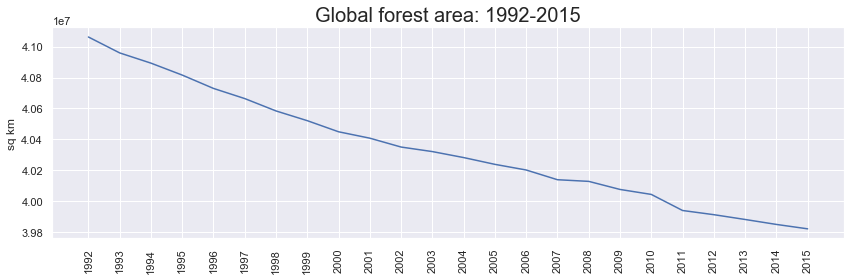

In [20]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
ax = sns.lineplot(x=forest_sum.index, y="sq km", data=forest_sum)
ax.set_xticklabels(labels=forest_sum.index, rotation=90)
ax.set_title('Global forest area: 1992-2015', fontsize=20)
fig.tight_layout()

In the next two charts we can examine the histogram of the forest area percent of the countries and forest area of the countries. The deforestation isn't so fast that we could see a real difference between 1992 and 2015. The histograms in the 'Histogram of the forest area percent of countries' chart are right skewed, so there is a lot of country with less than 20 percent forest, but there is only a few with more than 80 percent. The 'Histogram of the forest area of countries' shows, that there are some countries with very large forests, but most of the countries have a very small total forest area compared to them. This isn't are a surprise, there are more smaller countries than big ones.

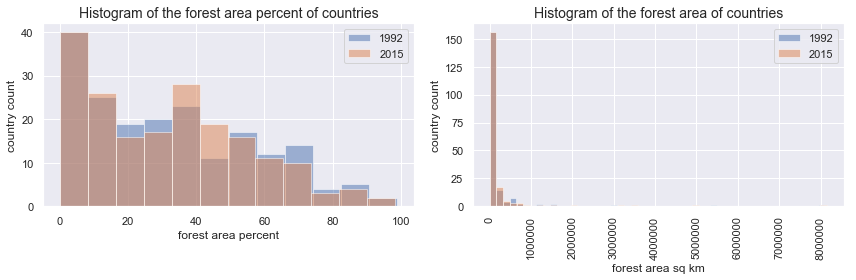

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

n, bins, patches = ax1.hist(df_forest_ratio['1992'].dropna(), alpha=0.5, bins=12)
n, bins, patches = ax1.hist(df_forest_ratio['2015'].dropna(), alpha=0.5, bins=12)

ax1.set_xlabel('forest area percent')
ax1.set_ylabel('country count')
ax1.set_title('Histogram of the forest area percent of countries', fontsize=14)
ax1.legend()

_ = ax2.hist(df_forest['1992'].dropna(), alpha=0.5, bins=50)
_ = ax2.hist(df_forest['2015'].dropna(), alpha=0.5, bins=50)

ax2.set_xlabel('forest area sq km')
ax2.set_ylabel('country count')
ax2.set_title('Histogram of the forest area of countries', fontsize=14)
plt.xticks(rotation='vertical')
ax2.legend()

fig.tight_layout()

Countries with the largest forest area:

In [22]:
top_fa = df_forest[['1992', '2015']].sort_values(by=['1992'], ascending=False).head(10)
top_fd = df_forest_ratio[['1992', '2015']].sort_values(by=['1992'], ascending=False).head(10)
top_fa

,1992,2015
geo,,
Russia,8090000.0,8150000.0
Brazil,5420000.0,4940000.0
Canada,3480000.0,3470000.0
United States,3030000.0,3100000.0
China,1610000.0,2080000.0
"Congo, Dem. Rep.",1600000.0,1530000.0
Australia,1290000.0,1250000.0
Indonesia,1150000.0,910000.0
Peru,776000.0,740000.0


Cumulative forest percent from the largest forest area:

In [23]:
df_forest = shape_data(df_forest)
forest_2015 = df_forest['2015'].sort_values(ascending=False)
forest_2015 = pd.DataFrame([forest_2015]).transpose()
forest_2015 = forest_2015.rename(columns={"2015": "area"})
world_total = forest_2015.sum()['area']
forest_2015['percent of global'] = (forest_2015 / world_total)*100
forest_2015['cumulative percent of global'] = forest_2015.cumsum()['percent of global']
forest_2015.head(10)

Column name 'geo' doesn't exist, returned the same dataframe.


,area,percent of global,cumulative percent of global
geo,,,
Russia,8150000.0,20.467058,20.467058
Brazil,4940000.0,12.405800,32.872857
Canada,3470000.0,8.714195,41.587053
United States,3100000.0,7.785016,49.372069
China,2080000.0,5.223495,54.595563
"Congo, Dem. Rep.",1530000.0,3.842282,58.437845
Australia,1250000.0,3.139119,61.576964
Indonesia,910000.0,2.285279,63.862243
Peru,740000.0,1.858359,65.720602


In "Top 10 forest countries by area" chart below, we can see the countries with the largest forests. Russia, Brasil, Canada and the US have half of the forests of the world.
"Top 10 forest countries by percent" shows the real forest countries, but they are relatively small.

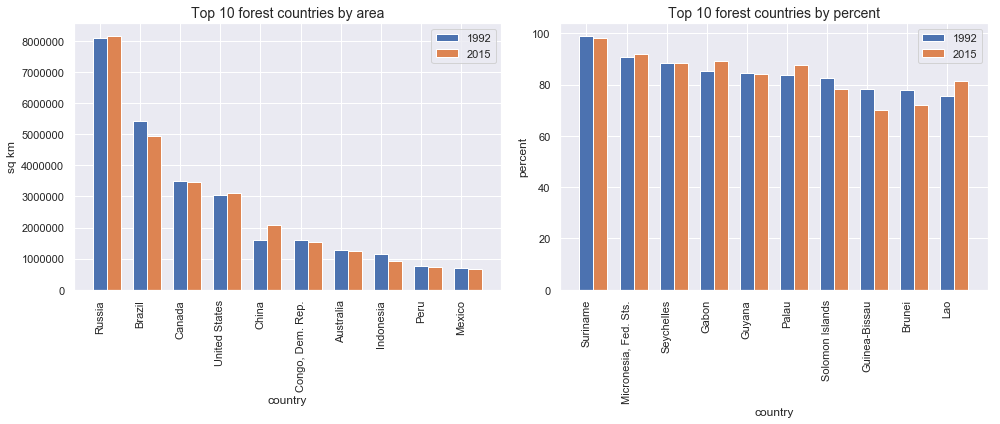

In [24]:
n_groups = 10
index = np.arange(n_groups)
bar_width = 0.35

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))

ax1.bar(index, top_fa['1992'], bar_width, label='1992', tick_label=n_groups) 
ax1.bar(index + bar_width, top_fa['2015'], bar_width, label='2015')
ax1.set_xlabel("country")
ax1.set_ylabel("sq km")
ax1.set_title("Top 10 forest countries by area", fontsize=14)
ax1.set_xticklabels(top_fa.index, rotation=90)
ax1.legend()

ax2.bar(index, top_fd['1992'], bar_width, label='1992', tick_label=n_groups) 
ax2.bar(index + bar_width, top_fd['2015'], bar_width, label='2015')
ax2.set_xlabel("country")
ax2.set_ylabel("percent")
ax2.set_title("Top 10 forest countries by percent", fontsize=14)
ax2.set_xticklabels(top_fd.index, rotation=90)
ax2.legend()
 
fig.tight_layout()

Calculate the largest forest growth and loss:

In [25]:
forestation = (df_forest['2015'] - df_forest['1992']).sort_values(ascending=False)
forestation_extremes = forestation[:5].append(forestation[-5:])
forestation_extremes.to_frame()

,0
geo,
China,470000.0
United States,70000.0
India,65000.0
Russia,60000.0
Vietnam,49600.0
Myanmar,-93000.0
Nigeria,-94100.0
Sudan,-112000.0
Indonesia,-240000.0


In [26]:
forestation_pc = (df_forest_ratio['2015'] - df_forest_ratio['1992']).sort_values(ascending=False)
forestation_pc_extremes = forestation_pc[:5].append(forestation_pc[-5:])
forestation_pc_extremes.to_frame()

,0
geo,
Bhutan,18.2
Vietnam,17.4
Dominican Republic,16.6
Montenegro,12.0
Samoa,11.6
Timor-Leste,-17.4
Cambodia,-18.1
Zimbabwe,-19.2
North Korea,-24.2


In the next chart "Countries with largest forest area change 1992-2015" we can see the countries with the largest forest area change. The rainforests of Brasil are smaller and smaller, and the other countries with the largest forest area loss are from the tropical zone as well. But fortunately there are countries where the forest area increased. A real surprise is China. The new forest area in China during the period is close to the loss of Brazil. According to this article [link](https://www.telegraph.co.uk/news/2018/01/05/china-plant-forest-size-ireland-bid-become-world-leader-conservation/) China made very serious efforts to increase its forest area.

Text(0,0.5,'sq km')

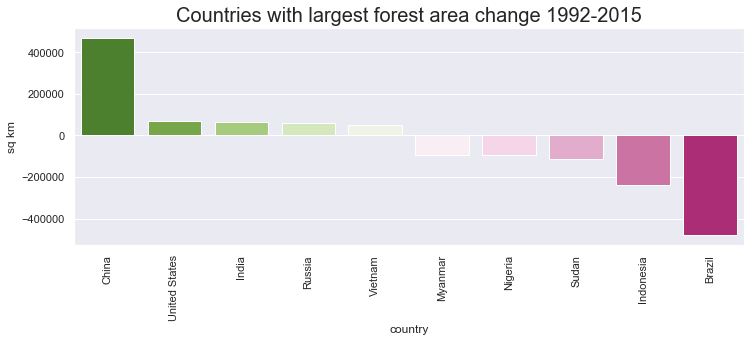

In [27]:
fig, ax1 = plt.subplots(figsize=(12,4))
ax1 = sns.barplot(forestation_extremes.index, forestation_extremes.values, palette='PiYG_r')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title("Countries with largest forest area change 1992-2015", fontsize=20)
ax1.set_xlabel("country")
ax1.set_ylabel("sq km")

In "Countries with largest forest percent change 1992-2015" we can see the top countries by forest area percent change.

Text(0,0.5,'sq km')

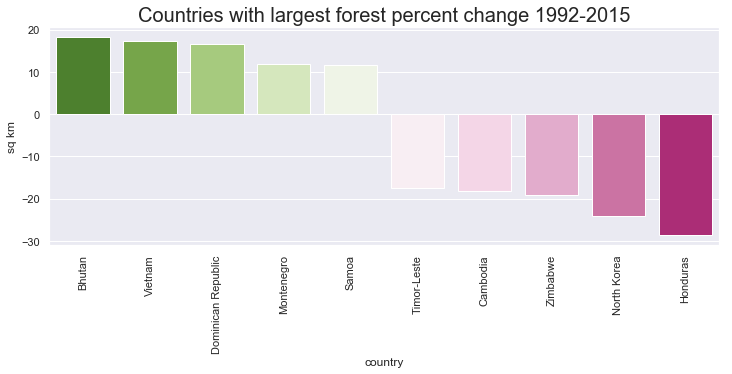

In [28]:
fig, ax2 = plt.subplots(figsize=(12,4))
ax2 = sns.barplot(forestation_pc_extremes.index, forestation_pc_extremes.values, palette='PiYG_r')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title("Countries with largest forest percent change 1992-2015", fontsize=20)
ax2.set_xlabel("country")
ax2.set_ylabel("sq km")

### Deforestation and the economic/demographic indicators


In this part I will try to find some connection between economic / demographic indicators and the forest area.

The 'country_correlation()' function used in the lambda expression below provides the correlation between the different indicators with the forest area for each country. Then I use the mean() method for these correlations. This way I get the average of the country correlations. Very important to note that these averages of the country correlations wouldn't equal the correlations between the indicators after calculating the global indicators. They have different meanings. For example, the average of the correlations of each countries forest area with the gdp of the corresponding country is different from the correlation of the global forest area with the global gdp. The first calculation views the countries as equals, and this is good for finding the general behavior of the countries. The second calculates the global trends regardless of the countries. Below I examine the countries, so I used the first calculation.

In [29]:
def country_correlation(row, df_tocorrelate):
    """
    Calculates the Paerson correlation between a dataframe row or a series and an other row in an other series with the same name.
    Arg:
        row (dataframe row or series): a row of input database
        df_tocorrelate (dataframe): a dataframe with the other row
    Return:
        float: the correlation coeficient
    """
    if df_tocorrelate.index.contains(row.name):
        return row.corr(df_tocorrelate.loc[row.name])       

The forest_area/forest_area correlation mean is 1, but the forest_ratio/forest_area is only 0.97. This difference can come from the handling of the missing values. The forest_ratio table had more missing values, and in different places than the forest area.

But the interesting things are in the other correlations. 

The total population of a country and the forest area of the country has a negative correlation on average. This seems reasonable, more people need more land, but as we saw above there are countries with opposite trends.

The agricultural land ratio has the strongest negative correlation with the forest area. Correlation isn't causation, but we can suspect that the agricultural area may expand at the expense of the forest area in some countries.

The gdp indicators don't show too high correlations with forest area, but we can try to further examine these indicators.

In [30]:
for k, v in df_dict.items():
    print(k + "/forest_area - mean correlation: ")
    print(df_forest.apply(axis=1, func=lambda x: country_correlation(x,v)).mean())
    print()

forest_area/forest_area - mean correlation: 
1.0

forest_ratio/forest_area - mean correlation: 
0.9723916187453951

population_total/forest_area - mean correlation: 
-0.14647306796708426

population_growth/forest_area - mean correlation: 
0.02585921338233156

population_density/forest_area - mean correlation: 
-0.14676544615624423

gdp_growth_pc/forest_area - mean correlation: 
-0.06129582651527704

gdp_tot/forest_area - mean correlation: 
0.010633015785713296

gdp_pc/forest_area - mean correlation: 
0.06281643567402515

agricultural_land_ratio/forest_area - mean correlation: 
-0.32519512673920686

agricultural_gdp_ratio/forest_area - mean correlation: 
-0.08153015076535342

surface_area/forest_area - mean correlation: 
0.03627464311698382

agro_area/forest_area - mean correlation: 
-0.3231877494136563



In the next part I will group the coutnries by gdp/capita: low, middle_low, middle_high and high, and see if the different groups have different correlations. I use income quartiles to group the countries.

In [31]:
df_gdp_pc['2015'].describe()

count       186.000000
mean      13335.870968
std       18619.685086
min         227.000000
25%        1715.000000
50%        5505.000000
75%       14825.000000
max      108000.000000
Name: 2015, dtype: float64

If we calculate the correlation averages by country groups we can see below that low income countries have the strongest negative correlations on average between the gdp/capita and forest area, and high income countries the strongest positive correlations on average.

In [32]:
low_inc = df_gdp_pc[df_gdp_pc['2015'] < df_gdp_pc['2015'].describe()['25%']]
mid_low_inc = df_gdp_pc[(df_gdp_pc['2015'] >= df_gdp_pc['2015'].describe()['25%']) & (df_gdp_pc['2015'] < df_gdp_pc['2015'].describe()['50%'])]
mid_high_inc = df_gdp_pc[(df_gdp_pc['2015'] >= df_gdp_pc['2015'].describe()['50%']) & (df_gdp_pc['2015'] < df_gdp_pc['2015'].describe()['75%'])]
high_inc = df_gdp_pc[df_gdp_pc['2015'] >= df_gdp_pc['2015'].describe()['75%']]
print("Correlation coefficient country averages - between forest ratio and gdp/capita")
print("low income countries:")
print(df_forest_ratio.apply(axis=1, func=lambda x: country_correlation(x,low_inc)).mean())
print("middle low income countries:")
print(df_forest_ratio.apply(axis=1, func=lambda x: country_correlation(x,mid_low_inc)).mean())
print("middle high income countries:")
print(df_forest_ratio.apply(axis=1, func=lambda x: country_correlation(x,mid_high_inc)).mean())
print("high income countries:")
print(df_forest_ratio.apply(axis=1, func=lambda x: country_correlation(x,high_inc)).mean())

Correlation coefficient country averages - between forest ratio and gdp/capita
low income countries:
-0.24604036973255042
middle low income countries:
0.0048908246128822105
middle high income countries:
0.12288758922125001
high income countries:
0.3764617463024202


The next charts show the scatterplots of the yearly average forest ratios in the income-group countries in different years and the yearly average gdp/capita in the income-group countries in different years. In the case of low income countries the higher is the gdp/capita, the lesser is the forest area in general. In the case of high income countries the higher is the gdp/capita, the higher is the forest area in general.

Text(0.5,0,'yearly average gdp/capita in the income-group countries in different years (US$)')

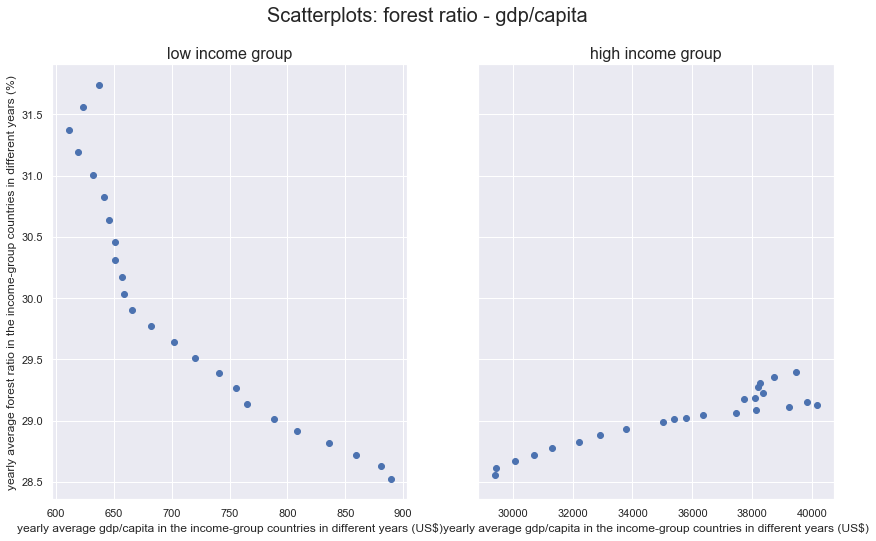

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,8), sharey=True)
fig.suptitle('Scatterplots: forest ratio - gdp/capita ', fontsize=20)

ax1.scatter(low_inc.dropna().mean(), df_forest_ratio.loc[low_inc.dropna().index].mean())
ax1.set_title("low income group", fontsize=16)
ax1.set_xlabel("yearly average gdp/capita in the income-group countries in different years (US$)")
ax1.set_ylabel("yearly average forest ratio in the income-group countries in different years (%)")

ax2.scatter(high_inc.dropna().mean(), df_forest_ratio.loc[high_inc.dropna().index].mean())
ax2.set_title("high income group", fontsize=16)
ax2.set_xlabel("yearly average gdp/capita in the income-group countries in different years (US$)")


After the countries we can examine the associations between global indicators. The next scatterplot shows the yearly total population and the yearly total forest area. This chart shows a very clear trend: as the total population gets larger, the forest area gets smaller.

Text(0,0.5,'forest area sq km')

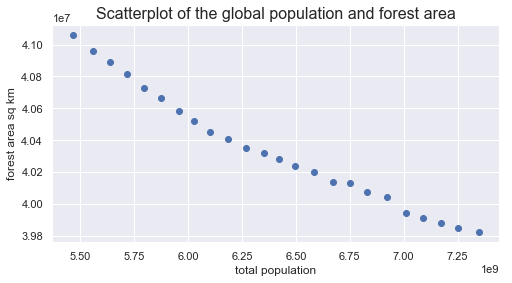

In [34]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

ax.scatter(df_popt.sum(), df_forest.sum())
ax.set_title("Scatterplot of the global population and forest area", fontsize=16)
ax.set_xlabel("total population")
ax.set_ylabel("forest area sq km")

I anticipated a very similar scatterplot from the global forest area and global agricultural area comparison, but I got something different below.

Text(0,0.5,'forest area sq km')

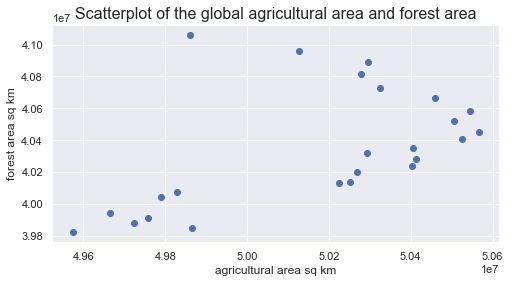

In [35]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

ax.scatter(df_agr_area.sum(), df_forest.sum())
ax.set_title("Scatterplot of the global agricultural area and forest area", fontsize=16)
ax.set_xlabel("agricultural area sq km")
ax.set_ylabel("forest area sq km")

After plotting the global agricultural area chart we can see that the global agricultural area isn't growing, instead of from 2000 it is decreasing as the global average forest area does.

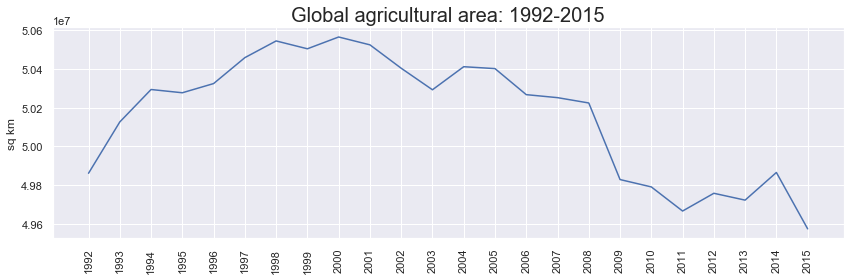

In [36]:
agr_area = df_agr_area.sum().to_frame('sq km')
fig, ax = plt.subplots(1,1, figsize=(12,4))
ax = sns.lineplot(x=agr_area.index, y="sq km", data=agr_area)
ax.set_xticklabels(labels=forest_sum.index, rotation=90)
ax.set_title('Global agricultural area: 1992-2015', fontsize=20)
fig.tight_layout()

<a id='conclusions'></a>
## Conclusions
The global average forest area is decreasing, but there are some good signs. Lots of countries increased their forest area, China made the strongest effort to plant new trees. The first four countries with the largest forests have the half of the global forests, and the first ten have the two thirds. After grouping the countries by income I found different correlations between the forest area of the countries and the gdp/capita, but to draw a conclusion it would require more examination.



